## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [3]:
import sys
sys.path.append("../../../../h2o-py/build/main") # path to h2o build

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OGradientBoostingEstimator
from h2o.estimators import H2OUpliftRandomForestEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.35.0',projectVersion='3.35.0.99999',branch='(HEAD detached at bd3753084c)',lastCommitHash='bd3753084c585e5d7dd3acd1070b25465c23c50f',gitDescribe='jenkins-master-5592-dirty',compiledOn='2021-10-14 17:49:30',compiledBy='potte'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [6]:
# Notebook parameters
N = 100000
P = 20

seed = 1234
ntrees = 100
attempt_per_thread = 10 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024

#Parameters to test
max_depths = [8, 16, 20]
nbinss = [20, 400, 2000]


In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OUpliftRandomForestEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                treatment_column=treatment_column,
                                                uplift_metric="KL",
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                auuc_type="gain"
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True,
                                      score_tree_interval=ntrees+1
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    start = time.time()
    gbm = H2OGradientBoostingEstimator(        
                                        ntrees=ntrees,
                                        max_depth=max_depth,
                                        distribution="bernoulli",
                                        gainslift_bins=10,
                                        min_rows=10,
                                        nbins_top_level=nbins_top_level,
                                        nbins=nbins,
                                        seed=seed,
                                        sample_rate=0.99,
                                        score_tree_interval=ntrees+1
                                      )
    gbm.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    gbm_time = end - start
    print(f"gbm Time: {gbm_time}s")    
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time, gbm_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    all_times_num_gbm = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        times_gbm = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time, gbm_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
            times_gbm.append(gbm_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        print(f"gbm {np.mean(times_gbm)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times_num_gbm.append(times_gbm)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s and gbm {np.mean(times_gbm)}s")

    uplift_means = dict()
    rf_means = dict()
    gbm_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}, gbm = {np.mean(all_times_num_gbm[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
        gbm_means[nthreads] = np.mean(all_times_num_gbm[i])
    
    return uplift_means, rf_means, gbm_means
        
    
def plot_result(eif_means, if_means, gbm_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    
        
    data_gbm = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_means.items():
        data_gbm["x"].append(label)
        data_gbm["y"].append(coord)         

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="UpliftRF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3)
    plt.plot(data_gbm['x'], data_gbm['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}; nbins = {nbins}")
    plt.savefig(f"h2o-scale-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [6]:
N = 100000
P = 20
max_depth = max_depths[0]
print(f"max_depth = {max_depth}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
uplift_time7, rf_time7, gbm_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjl5qe6zb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjl5qe6zb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjl5qe6zb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_potte_z6rfly
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.370450019836426s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.196329832077026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.256192207336426s
H2O session _sid_963c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe2i7pna1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe2i7pna1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe2i7pna1\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 minutes
H2O_cluster_name:,H2O_from_python_potte_q7bi1w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.181403398513794s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.764257192611694s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.29685926437378s
H2O session _sid_a2cd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvxz4prs_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvxz4prs_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvxz4prs_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 minutes
H2O_cluster_name:,H2O_from_python_potte_ynfpq9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.18930220603943s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.037269115447998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.422564506530762s
H2O session _sid_bac9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpepbq6wub
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpepbq6wub\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpepbq6wub\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_potte_mf6ubk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.48145866394043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.677323341369629s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.242515802383423s
H2O session _sid_9e79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxtycxbxs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxtycxbxs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxtycxbxs\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 minutes
H2O_cluster_name:,H2O_from_python_potte_4ucf79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.04574942588806s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.422605991363525s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 14.886961221694946s
H2O session _sid_aa63 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx5yqvahu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx5yqvahu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx5yqvahu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 minutes
H2O_cluster_name:,H2O_from_python_potte_1z2pcb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.114825963974s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.849250793457031s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.205982685089111s
H2O session _sid_baed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp66d6pdzm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp66d6pdzm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp66d6pdzm\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 minutes
H2O_cluster_name:,H2O_from_python_potte_ge91qj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.294633626937866s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.069205045700073s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.32418966293335s
H2O session _sid_9219 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptrq95dgf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptrq95dgf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptrq95dgf\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 minutes
H2O_cluster_name:,H2O_from_python_potte_75igog
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.31489849090576s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.097796440124512s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.495895147323608s
H2O session _sid_92ba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpajd3bqhl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpajd3bqhl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpajd3bqhl\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,24 minutes
H2O_cluster_name:,H2O_from_python_potte_tfh5vb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.07258343696594s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.890518188476562s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.48152756690979s
H2O session _sid_a655 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzmqqc63z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzmqqc63z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzmqqc63z\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_potte_k2odyn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.182087659835815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.812782764434814s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.479536294937134s
H2O session _sid_8efb closed.
Uplift 38.224739289283754s
RF 8.981733870506286s
gbm 13.309222435951233s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpao_r_0gt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpao_r_0gt\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,27 minutes
H2O_cluster_name:,H2O_from_python_potte_9clazj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.474395513534546s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.487436771392822s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.24862790107727s
H2O session _sid_8856 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphl5zw_mg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphl5zw_mg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphl5zw_mg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,28 minutes
H2O_cluster_name:,H2O_from_python_potte_58cbh4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.387187480926514s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.736226320266724s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.133141040802002s
H2O session _sid_92dd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq6k_tne4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq6k_tne4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq6k_tne4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,29 minutes
H2O_cluster_name:,H2O_from_python_potte_lq6zky
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.459232568740845s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.88243842124939s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.037906408309937s
H2O session _sid_9415 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3kxzp6p8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3kxzp6p8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3kxzp6p8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,31 minutes
H2O_cluster_name:,H2O_from_python_potte_qnp025
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.28030228614807s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.205064296722412s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.96809697151184s
H2O session _sid_ad14 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_4p67n81
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_4p67n81\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_4p67n81\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,32 minutes
H2O_cluster_name:,H2O_from_python_potte_7kg557
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.19022512435913s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.069281101226807s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.000839471817017s
H2O session _sid_8123 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5357rt4y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5357rt4y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5357rt4y\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,33 minutes
H2O_cluster_name:,H2O_from_python_potte_w4nnic
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.09543418884277s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.130896806716919s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.994495630264282s
H2O session _sid_aa84 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcg270pb1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcg270pb1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcg270pb1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,35 minutes
H2O_cluster_name:,H2O_from_python_potte_ushf5g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.21739888191223s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.848324298858643s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.120324611663818s
H2O session _sid_a0ec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpucj4l1p6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpucj4l1p6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpucj4l1p6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,36 minutes
H2O_cluster_name:,H2O_from_python_potte_4ml688
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.324251890182495s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.022802352905273s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.935401678085327s
H2O session _sid_ae10 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpli31cv4v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpli31cv4v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpli31cv4v\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,37 minutes
H2O_cluster_name:,H2O_from_python_potte_wqpmzo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.48357152938843s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.302645206451416s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.817824840545654s
H2O session _sid_b283 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5sig7h96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5sig7h96\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5sig7h96\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,39 minutes
H2O_cluster_name:,H2O_from_python_potte_rb6v59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.51515197753906s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.097859382629395s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.945977926254272s
H2O session _sid_953e closed.
Uplift 35.54271514415741s
RF 8.37829749584198s
gbm 12.020263648033142s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpihr7vdbr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpihr7vdbr\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,40 minutes
H2O_cluster_name:,H2O_from_python_potte_57byem
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.50536322593689s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.549445390701294s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.754887104034424s
H2O session _sid_9866 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdv5w3ghz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdv5w3ghz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdv5w3ghz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,41 minutes
H2O_cluster_name:,H2O_from_python_potte_rxrw0g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 33.964255809783936s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.551896095275879s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.67820930480957s
H2O session _sid_922f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw0_i_iqn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw0_i_iqn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw0_i_iqn\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_mgdpem
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.064178466796875s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.672587633132935s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.57366681098938s
H2O session _sid_b48e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1146frgq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1146frgq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1146frgq\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_6iv5jd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.331878900527954s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.484090089797974s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.680035591125488s
H2O session _sid_b6da closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0t9qezba
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0t9qezba\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0t9qezba\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,45 minutes
H2O_cluster_name:,H2O_from_python_potte_czbztg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.185481548309326s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.528358936309814s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.873347282409668s
H2O session _sid_b145 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdfodyzd2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdfodyzd2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdfodyzd2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,47 minutes
H2O_cluster_name:,H2O_from_python_potte_1btpv1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.23282790184021s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.502391815185547s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.810347318649292s
H2O session _sid_89e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8twg2q50
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8twg2q50\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8twg2q50\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,48 minutes
H2O_cluster_name:,H2O_from_python_potte_e7qsdv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.238774061203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.311675071716309s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.668572425842285s
H2O session _sid_9cc2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7vq3w1xi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7vq3w1xi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7vq3w1xi\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_potte_1ivqso
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.049948930740356s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.438530683517456s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.59203815460205s
H2O session _sid_9d86 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkj0ukwge
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkj0ukwge\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkj0ukwge\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_7wgsei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.2786865234375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.55796194076538s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.57712721824646s
H2O session _sid_9241 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjuer37mw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjuer37mw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjuer37mw\h2o_potte_started_from_python.err


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,52 minutes
H2O_cluster_name:,H2O_from_python_potte_v9zekd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.92546224594116s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.471060037612915s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.167186498641968s
H2O session _sid_aa57 closed.
Uplift 34.977685761451724s
RF 8.50679976940155s
gbm 11.637541770935059s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo4jgoscn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo4jgoscn\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_m7zy1n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.653470516204834s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.655147314071655s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.838494062423706s
H2O session _sid_a7b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0id2_shk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0id2_shk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0id2_shk\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_794las
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.52877140045166s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.59777307510376s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.66326642036438s
H2O session _sid_bdaf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqyob5r_j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqyob5r_j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqyob5r_j\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_dxr0zw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.70569109916687s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.51146388053894s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.539380311965942s
H2O session _sid_9bf2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9lcalric
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9lcalric\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9lcalric\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_potte_lx91pq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.55546450614929s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.553815603256226s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.464076519012451s
H2O session _sid_9253 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpezhd4j5f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpezhd4j5f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpezhd4j5f\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,59 minutes
H2O_cluster_name:,H2O_from_python_potte_bpprqw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.89166450500488s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.602693319320679s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.771904945373535s
H2O session _sid_8bfe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_rj1m_a0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_rj1m_a0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_rj1m_a0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour
H2O_cluster_name:,H2O_from_python_potte_c0krhr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.360668897628784s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.501319885253906s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.734009742736816s
H2O session _sid_9bc8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7c8vnw36
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7c8vnw36\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7c8vnw36\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 1 minute
H2O_cluster_name:,H2O_from_python_potte_3ifg2h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.02665328979492s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.55189847946167s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.126039266586304s
H2O session _sid_bf09 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyt5wgcqk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyt5wgcqk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyt5wgcqk\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_604p59
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.208245515823364s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.64403247833252s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.586387634277344s
H2O session _sid_87f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx80_pwak
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx80_pwak\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx80_pwak\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_mwka2g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.80598044395447s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.58247447013855s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.649099349975586s
H2O session _sid_af17 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn5a1ky0j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn5a1ky0j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn5a1ky0j\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_y3o1x9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.832194805145264s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.66570782661438s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.732338190078735s
H2O session _sid_b0d5 closed.
Uplift 36.35688049793244s
RF 8.686632633209229s
gbm 11.71049964427948s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmpqs8pnw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmpqs8pnw\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_rwqeh7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.76068425178528s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.87556004524231s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.724654912948608s
H2O session _sid_bfdb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9g_p03fa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9g_p03fa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9g_p03fa\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_e68lgt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.60351800918579s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.652434349060059s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.239405632019043s
H2O session _sid_aa47 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2yfgi35n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2yfgi35n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2yfgi35n\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_mlesix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.669872999191284s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.79030179977417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.939771175384521s
H2O session _sid_b0bd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl_10szy3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl_10szy3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl_10szy3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_u2vzgr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.840293884277344s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.786611080169678s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.757703065872192s
H2O session _sid_9c2c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpacjnr_ee
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpacjnr_ee\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpacjnr_ee\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_9q8npv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.4063503742218s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.729811906814575s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.796400785446167s
H2O session _sid_a159 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw_smnxf3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw_smnxf3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw_smnxf3\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_zudyfd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.663100481033325s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.697901964187622s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.210692405700684s
H2O session _sid_a493 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzm9ed6yd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzm9ed6yd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzm9ed6yd\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_9r7z4u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.54110383987427s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.644480466842651s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.690447568893433s
H2O session _sid_b030 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp63dnsqyv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp63dnsqyv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp63dnsqyv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_grt13c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.303494691848755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.696384191513062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.741358280181885s
H2O session _sid_8bdc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6ezhj881
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6ezhj881\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6ezhj881\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_u3vsz3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.57335376739502s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.667375564575195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.838164329528809s
H2O session _sid_bab0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkl4j5a8t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkl4j5a8t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkl4j5a8t\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_nzjuu4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 41.222644090652466s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.72389554977417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.794471025466919s
H2O session _sid_9c14 closed.
Uplift 40.158441638946535s
RF 9.826475691795348s
gbm 12.773306918144225s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzrmlldcg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzrmlldcg\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_lkf15n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.57136416435242s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.18410038948059s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.76147747039795s
H2O session _sid_bc04 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprz7o1lsx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprz7o1lsx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprz7o1lsx\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_y9thr3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.35447430610657s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.1483473777771s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.37142038345337s
H2O session _sid_803e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvyteh6pj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvyteh6pj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvyteh6pj\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_m2py0b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.111446142196655s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.066865682601929s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.37657332420349s
H2O session _sid_9c71 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplm6xlt27
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplm6xlt27\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplm6xlt27\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_ufjwb6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.41409111022949s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.13938021659851s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.460469961166382s
H2O session _sid_83eb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbryjbqar
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbryjbqar\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbryjbqar\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_2nuux2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.86934447288513s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.229394435882568s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.400485515594482s
H2O session _sid_a349 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3lxplp21
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3lxplp21\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3lxplp21\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_99bgtl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.41941046714783s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.724738597869873s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.67338991165161s
H2O session _sid_8ce6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppxutxc_n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppxutxc_n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppxutxc_n\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_bqkbu3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.1466965675354s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.17024850845337s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.52021622657776s
H2O session _sid_95d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzqgangsk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzqgangsk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzqgangsk\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_f8s20m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 63.64731001853943s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.21995759010315s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.698948860168457s
H2O session _sid_9b5f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4_vodun4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4_vodun4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4_vodun4\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_qh4z82
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.77283835411072s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.264394998550415s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.583770275115967s
H2O session _sid_9b94 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkophuncq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkophuncq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkophuncq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_0adku6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.69995141029358s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.041021585464478s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.777300596237183s
H2O session _sid_8fa9 closed.
Uplift 62.100692701339725s
RF 15.218844938278199s
gbm 20.362405252456664s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr5pogsz6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr5pogsz6\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_5cpnlu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.55254626274109s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.976629734039307s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.363221406936646s
H2O session _sid_b674 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp404kcrfe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp404kcrfe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp404kcrfe\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_2gdos3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.8671498298645s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 28.33456063270569s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.28502345085144s
H2O session _sid_aba9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb4uvsmy0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb4uvsmy0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb4uvsmy0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_f96vaq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.21011686325073s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.959718227386475s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.31321334838867s
H2O session _sid_a1cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptmprmx23
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptmprmx23\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptmprmx23\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_0jozsn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.09392762184143s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.207679271697998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.33016753196716s
H2O session _sid_aa5f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpikc3hwxt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpikc3hwxt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpikc3hwxt\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_ygbmue
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.66756224632263s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.21215271949768s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.44868302345276s
H2O session _sid_bfea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2mpvgar2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2mpvgar2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2mpvgar2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_sxbbtp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.67091798782349s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.160054206848145s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.29048442840576s
H2O session _sid_a5c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp131up2eu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp131up2eu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp131up2eu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_3hoasx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.10643196105957s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.9188334941864s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.035118103027344s
H2O session _sid_b071 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe4ebc0tf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe4ebc0tf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe4ebc0tf\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_vb0vyh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.97994828224182s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.959118843078613s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.16476082801819s
H2O session _sid_9407 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5rf3y7eu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5rf3y7eu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5rf3y7eu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_liap56
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.28917217254639s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.589157581329346s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 35.32421922683716s
H2O session _sid_b05a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8afqv9qa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8afqv9qa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8afqv9qa\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_ztrwhj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.48327994346619s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.402376413345337s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 35.65209174156189s
H2O session _sid_b189 closed.
Uplift 106.69210531711579s
RF 27.6720281124115s
gbm 36.120698308944704s
12 - Uplift = 38.224739289283754, RF = 8.981733870506286, gbm = 13.309222435951233
10 - Uplift = 35.54271514415741, RF = 8.37829749584198, gbm = 12.020263648033142
8 - Uplift = 34.977685761451724, RF = 8.50679976940155, gbm = 11.637541770935059
6 - Uplift = 36.35688049793244, RF = 8.686632633209229, gbm = 11.71049964427948
4 - Uplift = 40.158441638946535, RF = 9.826475691795348, gbm = 12.773306918144225
2 - Uplift = 62.1006

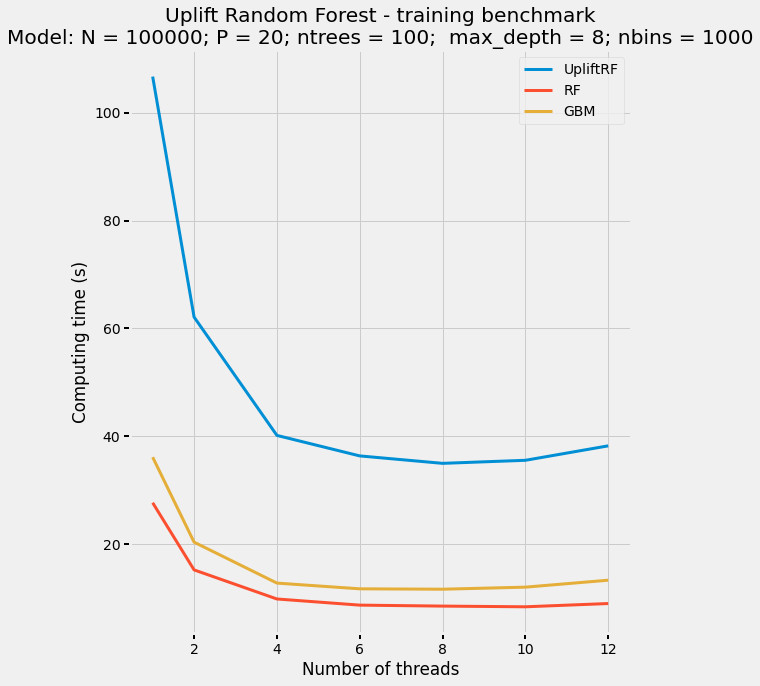

In [8]:
plot_result(uplift_time7, rf_time7, gbm_time7)

In [9]:
N = 100000
P = 20
max_depth = max_depths[1]
print(f"max_depth = {max_depth}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
uplift_time8, rf_time8, gbm_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8q1t7att
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8q1t7att\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8q1t7att\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_fharvo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 207.13340139389038s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.33834338188171s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 154.6716182231903s
H2O session _sid_9d23 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_uqmhe5b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_uqmhe5b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_uqmhe5b\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_q2yo4h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 207.3388147354126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.23349595069885s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.05310988426208s
H2O session _sid_9de9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvygk8r37
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvygk8r37\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvygk8r37\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_oc8z9a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 203.6948184967041s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.94886612892151s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.24596190452576s
H2O session _sid_a31e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw9m8kyhd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw9m8kyhd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw9m8kyhd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_nm2elg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 208.42298865318298s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.83983087539673s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.05515027046204s
H2O session _sid_9bd6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx4sougwg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx4sougwg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx4sougwg\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_ti2xqw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 206.8923420906067s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.2177791595459s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 158.40966749191284s
H2O session _sid_ac35 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphrilubxh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphrilubxh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphrilubxh\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_173404
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 203.86250972747803s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.6446533203125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 154.4500961303711s
H2O session _sid_92e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgj2_lliz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgj2_lliz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgj2_lliz\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_yl309n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 204.55676674842834s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.00906610488892s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.75531244277954s
H2O session _sid_9b88 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzhd7tjgb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzhd7tjgb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzhd7tjgb\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_6fhqe1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 205.24425148963928s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.70088529586792s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.21163082122803s
H2O session _sid_a52b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz53c0ln6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz53c0ln6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz53c0ln6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_5lvr79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 204.54361414909363s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.16250443458557s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 154.4546308517456s
H2O session _sid_ab8d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjat6wwn2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjat6wwn2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjat6wwn2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_6xipy4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 205.38466429710388s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.3712375164032s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.65402150154114s
H2O session _sid_a310 closed.
Uplift 205.707417178154s
RF 64.34666621685028s
gbm 155.69611995220185s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpapr5bux9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpapr5bux9\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_rymlyr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.84481954574585s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.983333587646484s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.49505400657654s
H2O session _sid_ac77 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3myyql9j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3myyql9j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3myyql9j\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_eowdhx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.59115433692932s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.262144565582275s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.34695148468018s
H2O session _sid_9d4b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa2wjusyw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa2wjusyw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa2wjusyw\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_6s49pz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.4437916278839s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.148592472076416s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.63678884506226s
H2O session _sid_b55f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb8xo_2ua
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb8xo_2ua\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb8xo_2ua\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_oezvsq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 192.40691685676575s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.96482706069946s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.60566926002502s
H2O session _sid_a23b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpae9hdmx2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpae9hdmx2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpae9hdmx2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_cou5ho
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.37855410575867s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.08527588844299s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.61292386054993s
H2O session _sid_a8bf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpef5hzfnd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpef5hzfnd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpef5hzfnd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_pcww39
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.04448580741882s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.303606271743774s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 144.94391655921936s
H2O session _sid_ad82 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnc9i2jmm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnc9i2jmm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnc9i2jmm\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_hqhvmj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.54123520851135s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.21064734458923s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 144.63016819953918s
H2O session _sid_82ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_w7xsb3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_w7xsb3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_w7xsb3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_9d79v6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.26982307434082s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.075857639312744s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.9688105583191s
H2O session _sid_9dd9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo_hvkztv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo_hvkztv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo_hvkztv\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_1ff9uy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.7303545475006s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.356067419052124s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.72314524650574s
H2O session _sid_a19d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3n3iz19i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3n3iz19i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3n3iz19i\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_aehirm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.27359986305237s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.95644021034241s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.2653670310974s
H2O session _sid_8d39 closed.
Uplift 191.25247349739075s
RF 58.13467924594879s
gbm 143.72287950515747s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ceij_hj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ceij_hj\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_90rmoi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.07087588310242s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.37319803237915s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.3358473777771s
H2O session _sid_902a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjvsrbxk8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjvsrbxk8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjvsrbxk8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_1zgnz8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.44317889213562s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.444812536239624s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.15026473999023s
H2O session _sid_b478 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu1pbvlpg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu1pbvlpg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu1pbvlpg\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_7wk4yi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 185.8437521457672s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.50690412521362s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.14547657966614s
H2O session _sid_9945 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_vw8cmkt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_vw8cmkt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_vw8cmkt\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_7qyf7f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.88825488090515s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.438453674316406s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.05650925636292s
H2O session _sid_93f6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppwsyqvb6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppwsyqvb6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppwsyqvb6\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_8agbeq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.73719263076782s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.581616163253784s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 133.68060183525085s
H2O session _sid_be72 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl9_bgh0q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl9_bgh0q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl9_bgh0q\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_8jp1cs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.79960465431213s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.46101784706116s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.7907531261444s
H2O session _sid_880a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9a3ow_x3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9a3ow_x3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9a3ow_x3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_e32di3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.8408989906311s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.46004915237427s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.86143922805786s
H2O session _sid_8aab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6tucsxa8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6tucsxa8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6tucsxa8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_f5amrs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.56963682174683s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.223843574523926s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.0370044708252s
H2O session _sid_bb2b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_a7gip3x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_a7gip3x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_a7gip3x\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_wgbrsw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.17757987976074s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.33714938163757s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.25952053070068s
H2O session _sid_85bc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzra6of5y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzra6of5y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzra6of5y\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_cwiopc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.3567488193512s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.27413725852966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 128.96434783935547s
H2O session _sid_941f closed.
Uplift 184.172772359848s
RF 54.21011817455292s
gbm 132.02817649841307s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt9u9r0k8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt9u9r0k8\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_l5bn66
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.13480281829834s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.17735409736633s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.10006594657898s
H2O session _sid_b50d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpslt0djh_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpslt0djh_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpslt0djh_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_bxps2u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 178.3001639842987s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.99660563468933s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 121.91630840301514s
H2O session _sid_8c19 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjk2acwfo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjk2acwfo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjk2acwfo\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_zy4p66
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.48424625396729s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.46358561515808s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 122.1203100681305s
H2O session _sid_a1e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbx3gcm_z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbx3gcm_z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbx3gcm_z\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_1v5w49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.40443015098572s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.815211057662964s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 121.8816328048706s
H2O session _sid_ba0b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcpl552aw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcpl552aw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcpl552aw\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_cn9c8g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.46184086799622s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.92960262298584s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 121.61507987976074s
H2O session _sid_acb5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz0qpjzzd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz0qpjzzd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz0qpjzzd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_2cwtr8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.99058055877686s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.89226460456848s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 122.16606664657593s
H2O session _sid_a8c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjkupq6_o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjkupq6_o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjkupq6_o\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_b8qpkc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.18097305297852s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.916765451431274s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.44698691368103s
H2O session _sid_a409 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3gyfx_qv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3gyfx_qv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3gyfx_qv\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_q6o1qm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 179.8801429271698s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.95034408569336s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.367107629776s
H2O session _sid_b989 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4a7n7du3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4a7n7du3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4a7n7du3\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_tji8br
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.00109028816223s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.775455474853516s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 121.63050532341003s
H2O session _sid_a673 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvb_4zbq1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvb_4zbq1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvb_4zbq1\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_1a6kyy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.3857865333557s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.86052060127258s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 121.81158137321472s
H2O session _sid_a09f closed.
Uplift 181.22240574359893s
RF 51.67777092456818s
gbm 122.30556449890136s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq3grucwu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq3grucwu\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_fan5it
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.80056762695312s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.180458068847656s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 115.6569766998291s
H2O session _sid_a274 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5uqiwfe9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5uqiwfe9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5uqiwfe9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_zw0z8l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 185.08325481414795s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.151885986328125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.97428464889526s
H2O session _sid_bc19 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpixvgc_zz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpixvgc_zz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpixvgc_zz\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours
H2O_cluster_name:,H2O_from_python_potte_zlndmh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.14603281021118s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 56.51548480987549s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.81902933120728s
H2O session _sid_b064 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpglfryz7q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpglfryz7q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpglfryz7q\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_mj5fs2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.8663091659546s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.80705523490906s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.62496662139893s
H2O session _sid_b025 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpovc984xv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpovc984xv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpovc984xv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_ikfwtd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.01676535606384s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.91939353942871s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 112.51416110992432s
H2O session _sid_8b7e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb6ahryll
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb6ahryll\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb6ahryll\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_3dg9gj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 185.80055832862854s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.03562784194946s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.46014499664307s
H2O session _sid_a222 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbzezoex0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbzezoex0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbzezoex0\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_79i98s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.46207785606384s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.15766787528992s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.53953003883362s
H2O session _sid_ad49 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpki5z1tfn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpki5z1tfn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpki5z1tfn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_mvuiqn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.89190864562988s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.03469920158386s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.45402431488037s
H2O session _sid_9326 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptfguh8l5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptfguh8l5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptfguh8l5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_pow4l6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 189.19388484954834s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.01440238952637s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.82838582992554s
H2O session _sid_8faa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp81lxw0th
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp81lxw0th\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp81lxw0th\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_y4evfb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.17778778076172s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.25256109237671s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 112.55215454101562s
H2O session _sid_87f1 closed.
Uplift 183.9439147233963s
RF 53.40692360401154s
gbm 113.94236581325531s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuy8rkp94
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuy8rkp94\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_sbnt1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.50578474998474s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.84495568275452s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 141.21588587760925s
H2O session _sid_8b4d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4xk9k0m5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4xk9k0m5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4xk9k0m5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_agcf0z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.729398727417s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.32127714157104s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 140.3630805015564s
H2O session _sid_9923 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx3f7lm6x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx3f7lm6x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx3f7lm6x\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_g3v49i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 265.6818382740021s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.89113903045654s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 137.42359161376953s
H2O session _sid_af79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfiqqkp2u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfiqqkp2u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfiqqkp2u\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_rh2vdr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 262.71325302124023s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.57377672195435s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 141.92448711395264s
H2O session _sid_8a04 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdh__mhku
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdh__mhku\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdh__mhku\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_rd1q7f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.2554876804352s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.0696177482605s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 141.45662117004395s
H2O session _sid_8d02 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpypielv5y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpypielv5y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpypielv5y\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_rz7kz4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 264.44491314888s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 79.12132906913757s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 141.70831775665283s
H2O session _sid_a230 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp245s_sun
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp245s_sun\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp245s_sun\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_0r1ufm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 265.5054132938385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.71795558929443s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 141.63493609428406s
H2O session _sid_a2a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv8_geh0u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv8_geh0u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv8_geh0u\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_eb9pgt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.1320197582245s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.99342823028564s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 139.60255074501038s
H2O session _sid_b5f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc72tfycb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc72tfycb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc72tfycb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_5ciakc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 265.47634053230286s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.53244137763977s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 139.4442219734192s
H2O session _sid_9664 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwkj61u0j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwkj61u0j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwkj61u0j\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_m9t1g5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 265.36771845817566s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.30748414993286s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 140.6699619293213s
H2O session _sid_a4db closed.
Uplift 265.4812167644501s
RF 78.03734047412873s
gbm 140.54436547756194s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpghvga62h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpghvga62h\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_l13724
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 461.89646458625793s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 143.22180557250977s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.60182666778564s
H2O session _sid_aa95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5hx4r1rh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5hx4r1rh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5hx4r1rh\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_a1gbfg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 455.8529555797577s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 145.59385442733765s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 213.21521735191345s
H2O session _sid_a1b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn96ap4uf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn96ap4uf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn96ap4uf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_dghy4g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 459.58948016166687s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.8526587486267s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 219.0012924671173s
H2O session _sid_ada9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprmt4uyi8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprmt4uyi8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprmt4uyi8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_1cwpd8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 459.5317761898041s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 142.57006692886353s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 218.91110348701477s
H2O session _sid_a443 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppl750323
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppl750323\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppl750323\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_4s9bfw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 459.34877157211304s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.8555257320404s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 219.3105754852295s
H2O session _sid_8ec0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnhh_6drl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnhh_6drl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnhh_6drl\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_v3j3fv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 453.7000696659088s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.78019857406616s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 215.5617642402649s
H2O session _sid_8efb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3m5klvkh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3m5klvkh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3m5klvkh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_xzbhwq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 455.3589358329773s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.54363632202148s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 215.8508176803589s
H2O session _sid_9eae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj6i_2fmk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj6i_2fmk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj6i_2fmk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_u3l0i1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 459.63323974609375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 148.60645842552185s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.1546289920807s
H2O session _sid_843f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvptb9zsf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvptb9zsf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvptb9zsf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_dy53zd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 454.23872566223145s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.74195408821106s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.92978167533875s
H2O session _sid_903f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkels0r6y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkels0r6y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkels0r6y\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_p9tm0t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 460.6045458316803s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 145.57962465286255s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 208.67758655548096s
H2O session _sid_a5bc closed.
Uplift 457.9754964828491s
RF 146.2345783472061s
gbm 217.4214594602585s
12 - Uplift = 205.707417178154, RF = 64.34666621685028, gbm = 155.69611995220185
10 - Uplift = 191.25247349739075, RF = 58.13467924594879, gbm = 143.72287950515747
8 - Uplift = 184.172772359848, RF = 54.21011817455292, gbm = 132.02817649841307
6 - Uplift = 181.22240574359893, RF = 51.67777092456818, gbm = 122.30556449890136
4 - Uplift = 183.9439147233963, RF = 53.40692360401154, gbm = 113.94236581325531
2 - Uplift = 265.4812

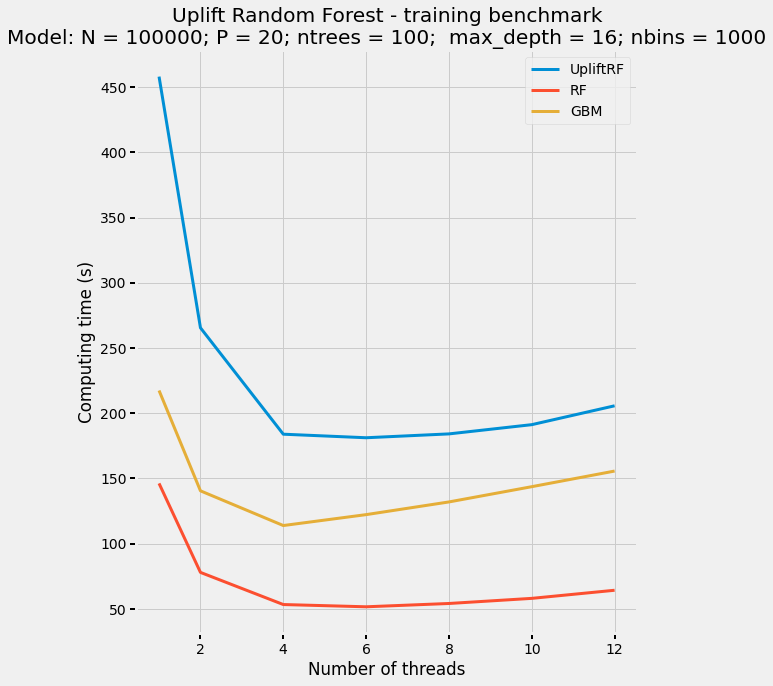

In [11]:
plot_result(uplift_time8, rf_time8, gbm_time8)

### Bigger sample_size

In [12]:
N = 100000
P = 20
max_depth = max_depths[2]
print(f"max_depth = {max_depth}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
uplift_time9, rf_time9, gbm_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeaiz37e3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeaiz37e3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeaiz37e3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_wwbijo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.7853784561157s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.18646383285522s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 279.5334906578064s
H2O session _sid_8ce4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa8u_g9dm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa8u_g9dm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa8u_g9dm\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_laavps
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.0596640110016s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.65349960327148s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 287.77641916275024s
H2O session _sid_bbb0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfu4_9hwi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfu4_9hwi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfu4_9hwi\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_i55vuf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.2867691516876s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.86249995231628s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 283.17456340789795s
H2O session _sid_b8a6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwxb4dmum
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwxb4dmum\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwxb4dmum\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_4czcb1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.85565638542175s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.79033398628235s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 286.4005162715912s
H2O session _sid_a380 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3zofnrzp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3zofnrzp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3zofnrzp\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_hgr7w4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.90742588043213s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.1608669757843s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.20093059539795s
H2O session _sid_a3be closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu5arfprf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu5arfprf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu5arfprf\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_2ze9w4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.94148421287537s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.90483236312866s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.2886118888855s
H2O session _sid_85f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9rdl61xb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9rdl61xb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9rdl61xb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_txkxw5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.092173576355s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.54372262954712s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 284.8228180408478s
H2O session _sid_9eae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9f0d77rm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9f0d77rm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9f0d77rm\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_f4ef7q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.2872533798218s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.36827659606934s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 283.569926738739s
H2O session _sid_8c04 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb2vzbrxv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb2vzbrxv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb2vzbrxv\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_f8eftk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 311.89948296546936s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.14359998703003s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 284.29290413856506s
H2O session _sid_bbf7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7ahgt9_8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7ahgt9_8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7ahgt9_8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_y0u5gm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 318.23903942108154s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.63504481315613s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.1284832954407s
H2O session _sid_a2a0 closed.
Uplift 315.5354327440262s
RF 75.4249140739441s
gbm 283.41886641979215s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc_gkd20z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc_gkd20z\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_i12tva
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.2123670578003s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.3154194355011s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 261.2331109046936s
H2O session _sid_8c4d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx6ckfdmd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx6ckfdmd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx6ckfdmd\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_d5u1oq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.10700821876526s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.40810060501099s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 260.9395008087158s
H2O session _sid_9c18 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjlcptvc2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjlcptvc2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjlcptvc2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_cemspz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.5585479736328s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.3403091430664s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 260.15568494796753s
H2O session _sid_abf2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk4qoh73m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk4qoh73m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk4qoh73m\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_cyfnci
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.8781433105469s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.54721140861511s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.19677114486694s
H2O session _sid_97d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfjpui5sj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfjpui5sj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfjpui5sj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_3ud1yr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.8822371959686s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.14838147163391s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.8467559814453s
H2O session _sid_9af2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5wudfo3a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5wudfo3a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5wudfo3a\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_9siohw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.60927748680115s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.20760154724121s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.926899433136s
H2O session _sid_bf87 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp99n_ks40
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp99n_ks40\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp99n_ks40\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_jzf9vn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.35885214805603s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.90206408500671s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.71604466438293s
H2O session _sid_adbc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpksbnukwm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpksbnukwm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpksbnukwm\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_kn9ecp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.5014569759369s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.18852591514587s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.46474146842957s
H2O session _sid_a531 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmjx_aes3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmjx_aes3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmjx_aes3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_3asnoj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 288.66585206985474s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.96945118904114s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 256.70648884773254s
H2O session _sid_a321 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppcgt95vd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppcgt95vd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppcgt95vd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_1g9z5a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 290.72717213630676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.41953325271606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 257.18410181999207s
H2O session _sid_937c closed.
Uplift 293.85009145736694s
RF 70.54465980529785s
gbm 259.03701000213624s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1h2o5gvn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1h2o5gvn\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_uyg8n1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.5369863510132s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.67810559272766s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.77720975875854s
H2O session _sid_8ab5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp21wcpl3d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp21wcpl3d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp21wcpl3d\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_xfnunc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.42571997642517s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.42826390266418s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.67345333099365s
H2O session _sid_999d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpahrv3vco
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpahrv3vco\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpahrv3vco\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_9otrbe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 279.7088441848755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.53268480300903s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.81934332847595s
H2O session _sid_a859 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb9yys1c9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb9yys1c9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb9yys1c9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_bad0dn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.40218901634216s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.40547156333923s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.08159232139587s
H2O session _sid_aad5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfuvynba_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfuvynba_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfuvynba_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours
H2O_cluster_name:,H2O_from_python_potte_o3ba9j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 279.63583850860596s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.46880173683167s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 235.86732244491577s
H2O session _sid_821d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_axaki_u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_axaki_u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_axaki_u\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_5v4vjt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.9593505859375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.54005551338196s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.83384084701538s
H2O session _sid_879c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzhjsm3ip
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzhjsm3ip\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzhjsm3ip\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_lt5w1q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 280.2053301334381s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.30357074737549s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 234.2943353652954s
H2O session _sid_99f1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqowpwx5e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqowpwx5e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqowpwx5e\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_efyw2d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 280.27984404563904s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.57104873657227s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.39979672431946s
H2O session _sid_b72b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbbwy6j1s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbbwy6j1s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbbwy6j1s\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_g8m82s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 280.9864764213562s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.6790976524353s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.89764499664307s
H2O session _sid_a249 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz4ix2_h5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz4ix2_h5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz4ix2_h5\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_tt3szp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 279.34909200668335s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.80422878265381s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.75595450401306s
H2O session _sid_b504 closed.
Uplift 281.0489671230316s
RF 65.44113290309906s
gbm 237.9400493621826s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpesa8f4aa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpesa8f4aa\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_fssdhx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.4727578163147s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.4393835067749s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.6038408279419s
H2O session _sid_93bb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphrf6_jzz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphrf6_jzz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphrf6_jzz\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_juixgn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 270.93275260925293s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.82796812057495s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 217.7220060825348s
H2O session _sid_a132 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoodd_0pv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoodd_0pv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoodd_0pv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_j4pxqg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.66849660873413s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.99560236930847s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.92019748687744s
H2O session _sid_8497 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6btd4egt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6btd4egt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6btd4egt\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_kv1kpl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.173321723938s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.850011110305786s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.6819145679474s
H2O session _sid_b5c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4yqrthmu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4yqrthmu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4yqrthmu\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_l3kqpq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 276.0627634525299s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.50282883644104s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.50981521606445s
H2O session _sid_9005 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzlenwc_k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzlenwc_k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzlenwc_k\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_8h0gqf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.8718099594116s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.099703550338745s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 216.58952379226685s
H2O session _sid_9afb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5aubxnp8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5aubxnp8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5aubxnp8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_krg18l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.84111762046814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.15042591094971s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 218.06388306617737s
H2O session _sid_af6e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsatwdwp6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsatwdwp6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsatwdwp6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_qqncxr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 275.450430393219s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.209617614746094s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.311270236969s
H2O session _sid_b127 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_ljz4bay
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_ljz4bay\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_ljz4bay\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_5l9n4z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.25544023513794s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.123902320861816s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 219.54394841194153s
H2O session _sid_bd9a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2hdi7n81
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2hdi7n81\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2hdi7n81\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_tf549o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.83998680114746s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.93050670623779s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 218.03935956954956s
H2O session _sid_b464 closed.
Uplift 272.9568877220154s
RF 61.31299500465393s
gbm 219.69857592582701s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuypqdwas
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuypqdwas\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_umv930
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.29494643211365s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.33263397216797s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.2975127696991s
H2O session _sid_86ef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd2e90zqw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd2e90zqw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd2e90zqw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_4f4tkl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.8580675125122s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.33601689338684s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.48960709571838s
H2O session _sid_91a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfxum9tpp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfxum9tpp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfxum9tpp\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_p7s9y4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.79418778419495s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.28869676589966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 201.21517181396484s
H2O session _sid_ba9e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprosb0d3c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprosb0d3c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprosb0d3c\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_ga96et
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.135231256485s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.26710915565491s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.2497353553772s
H2O session _sid_a7b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprwg3w61l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprwg3w61l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprwg3w61l\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_xvdtih
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.34340143203735s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.26062870025635s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 200.35657453536987s
H2O session _sid_844c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8zmt8rxz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8zmt8rxz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8zmt8rxz\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_2wrjww
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.88448214530945s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.04469585418701s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 202.18092155456543s
H2O session _sid_a89a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbf71n0hf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbf71n0hf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbf71n0hf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_4r0zkl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.94825887680054s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.78375196456909s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.1095290184021s
H2O session _sid_a1c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0t3ss27o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0t3ss27o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0t3ss27o\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_zt38he
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.71785974502563s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.35496425628662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 201.8734486103058s
H2O session _sid_9d79 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaywot3q8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaywot3q8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaywot3q8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_k656vx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 272.5379683971405s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.339946269989014s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 201.83835792541504s
H2O session _sid_a17a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5ock8032
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5ock8032\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5ock8032\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_30jbcw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.8740608692169s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.514671087265015s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.59609031677246s
H2O session _sid_99ce closed.
Uplift 269.5388464450836s
RF 63.85231149196625s
gbm 202.72069489955902s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzanx2eo_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzanx2eo_\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_mog1jv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 382.50259041786194s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.8854444026947s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 243.74973511695862s
H2O session _sid_bd36 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc02sk5j4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc02sk5j4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc02sk5j4\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_uxov49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.9426233768463s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.086341381073s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.27253913879395s
H2O session _sid_9be4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpscrhfk02
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpscrhfk02\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpscrhfk02\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_qxh8m3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.07509899139404s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.47872304916382s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.5778136253357s
H2O session _sid_85cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqpzcwczu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqpzcwczu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqpzcwczu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_htwj64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 386.23815536499023s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.05528259277344s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 234.35238337516785s
H2O session _sid_af3c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6layfk7i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6layfk7i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6layfk7i\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours
H2O_cluster_name:,H2O_from_python_potte_uajnyt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.4657781124115s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.22807145118713s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.11108899116516s
H2O session _sid_b4de closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz9020smm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz9020smm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz9020smm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_0h440h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.41583275794983s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.61000919342041s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.9343967437744s
H2O session _sid_829c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpefe05xdt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpefe05xdt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpefe05xdt\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_u5zvnk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 379.5833923816681s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.15489792823792s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.89738202095032s
H2O session _sid_b5a0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4zfybbw4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4zfybbw4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4zfybbw4\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_ospp1x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.8910176753998s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.14643144607544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.73051619529724s
H2O session _sid_b6d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfeuvw0xb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfeuvw0xb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfeuvw0xb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_r13lai
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 385.13729977607727s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.9857451915741s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.986172914505s
H2O session _sid_a5dc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq9_r0sgh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq9_r0sgh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq9_r0sgh\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_fd2g5i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 380.72387194633484s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.80126070976257s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.67824053764343s
H2O session _sid_a7af closed.
Uplift 382.79756608009336s
RF 95.04322073459625s
gbm 242.12902686595916s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuo4h9oc3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuo4h9oc3\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_122x2d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 654.2016787528992s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 175.25880908966064s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 355.09886145591736s
H2O session _sid_b905 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfpjppttn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfpjppttn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfpjppttn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_vdrfb6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 655.699384689331s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 180.66740536689758s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 372.6785624027252s
H2O session _sid_908e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppjew38kx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppjew38kx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppjew38kx\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_3f3vjr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 652.5779130458832s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 179.12571835517883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 369.76413345336914s
H2O session _sid_9771 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_bwncoy_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_bwncoy_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_bwncoy_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_m8vjhp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 664.9361310005188s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 175.13345956802368s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 365.34511137008667s
H2O session _sid_a2a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbdiabzvb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbdiabzvb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbdiabzvb\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_1d07ay
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 655.7019724845886s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 180.609304189682s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 373.9701235294342s
H2O session _sid_9d3a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5wuu5kv_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5wuu5kv_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5wuu5kv_\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_up2dae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 650.8773040771484s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 180.69585847854614s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.58378434181213s
H2O session _sid_8aba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpktyeiy8v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpktyeiy8v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpktyeiy8v\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4tjx3f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 652.5194568634033s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.50370359420776s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 366.81986808776855s
H2O session _sid_a7b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmw6d6j2i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmw6d6j2i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmw6d6j2i\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qfcm38
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 644.232127904892s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 180.2747642993927s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 372.38749718666077s
H2O session _sid_a117 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcoj05iux
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcoj05iux\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcoj05iux\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5oe2wp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 659.4109723567963s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 179.07841753959656s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 379.09975957870483s
H2O session _sid_bbdc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyjyp69eb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyjyp69eb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyjyp69eb\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pn2r41
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 659.4744741916656s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.20964574813843s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 373.778507232666s
H2O session _sid_aa8f closed.
Uplift 654.9631415367127s
RF 178.55570862293243s
gbm 369.0526208639145s
12 - Uplift = 315.5354327440262, RF = 75.4249140739441, gbm = 283.41886641979215
10 - Uplift = 293.85009145736694, RF = 70.54465980529785, gbm = 259.03701000213624
8 - Uplift = 281.0489671230316, RF = 65.44113290309906, gbm = 237.9400493621826
6 - Uplift = 272.9568877220154, RF = 61.31299500465393, gbm = 219.69857592582701
4 - Uplift = 269.5388464450836, RF = 63.85231149196625, gbm = 202.72069489955902
2 - Uplift = 382.797566

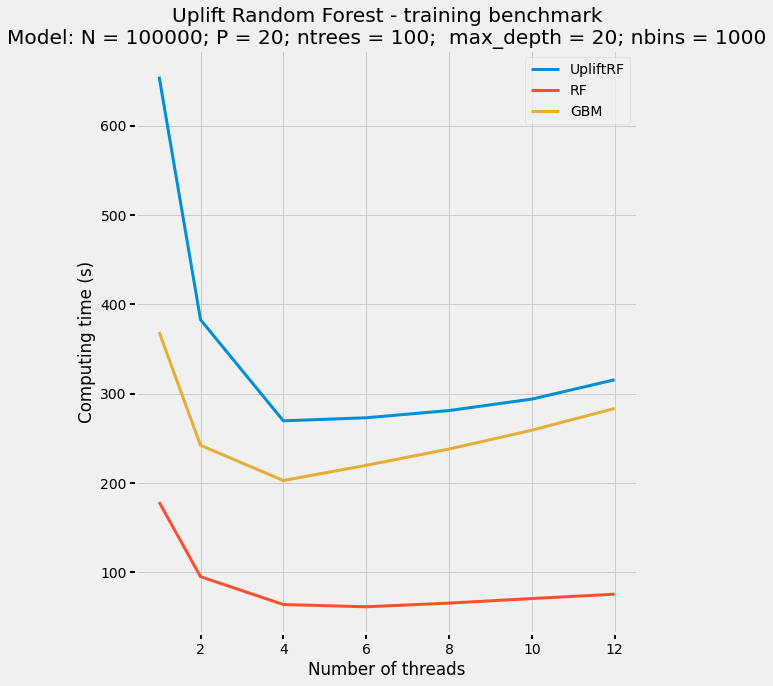

In [14]:
plot_result(uplift_time9, rf_time9, gbm_time9)

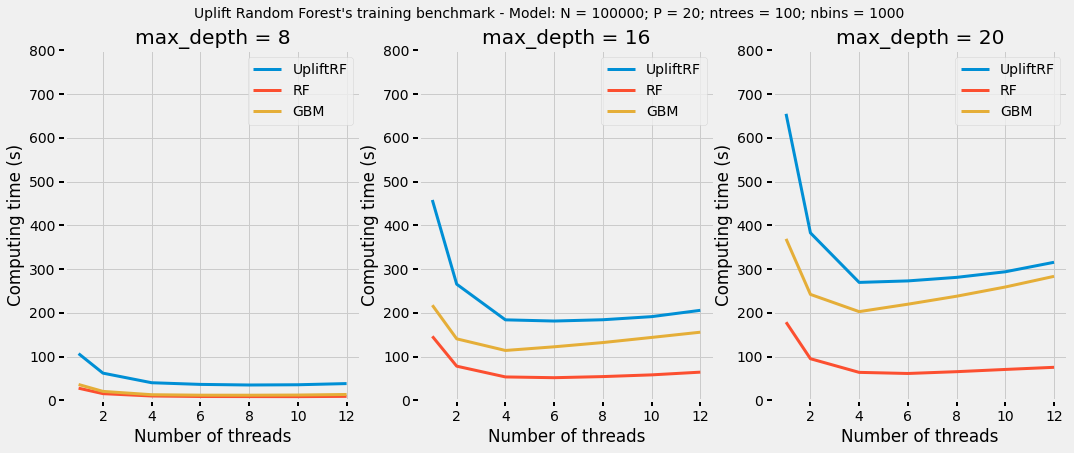

In [15]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 38.224739289283754, 10: 35.54271514415741, 8: 34.977685761451724, 6: 36.35688049793244, 4: 40.158441638946535, 2: 62.100692701339725, 1: 106.69210531711579}, {12: 205.707417178154, 10: 191.25247349739075, 8: 184.172772359848, 6: 181.22240574359893, 4: 183.9439147233963, 2: 265.4812167644501, 1: 457.9754964828491}, {12: 315.5354327440262, 10: 293.85009145736694, 8: 281.0489671230316, 6: 272.9568877220154, 4: 269.5388464450836, 2: 382.79756608009336, 1: 654.9631415367127}]


In [17]:
print(all_predict_rf)

[{12: 8.981733870506286, 10: 8.37829749584198, 8: 8.50679976940155, 6: 8.686632633209229, 4: 9.826475691795348, 2: 15.218844938278199, 1: 27.6720281124115}, {12: 64.34666621685028, 10: 58.13467924594879, 8: 54.21011817455292, 6: 51.67777092456818, 4: 53.40692360401154, 2: 78.03734047412873, 1: 146.2345783472061}, {12: 75.4249140739441, 10: 70.54465980529785, 8: 65.44113290309906, 6: 61.31299500465393, 4: 63.85231149196625, 2: 95.04322073459625, 1: 178.55570862293243}]


In [18]:
print(all_predict_gbm)

[{12: 13.309222435951233, 10: 12.020263648033142, 8: 11.637541770935059, 6: 11.71049964427948, 4: 12.773306918144225, 2: 20.362405252456664, 1: 36.120698308944704}, {12: 155.69611995220185, 10: 143.72287950515747, 8: 132.02817649841307, 6: 122.30556449890136, 4: 113.94236581325531, 2: 140.54436547756194, 1: 217.4214594602585}, {12: 283.41886641979215, 10: 259.03701000213624, 8: 237.9400493621826, 6: 219.69857592582701, 4: 202.72069489955902, 2: 242.12902686595916, 1: 369.0526208639145}]


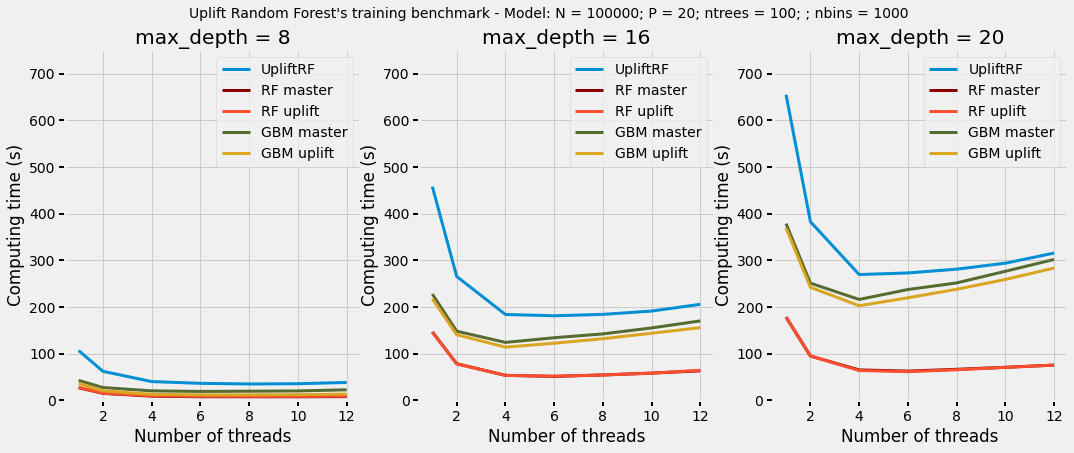

In [20]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf_uplift = [rf_time7, rf_time8, rf_time9]
all_predict_gbm_uplift = [gbm_time7, gbm_time8, gbm_time9]
all_predict_gbm_master = [{12: 22.480031037330626, 10: 20.100569820404054, 8: 19.50397570133209, 6: 19.02869620323181, 4: 20.260752630233764, 2: 27.356335163116455, 1: 42.66778080463409}, {12: 170.18061714172364, 10: 155.1232393026352, 8: 142.310054397583, 6: 134.1138013601303, 4: 124.05112998485565, 2: 148.1445460319519, 1: 227.6855852842331}, {12: 301.867510843277, 10: 276.53642892837524, 8: 251.56781561374663, 6: 237.37603039741515, 4: 216.16113529205322, 2: 251.0626908302307, 1: 378.6919209241867}]
all_predict_rf_master = [{12: 7.952457348505656, 10: 7.589529991149902, 8: 7.599389672279358, 6: 7.7046345472335815, 4: 8.885488470395407, 2: 14.876623670260111, 1: 26.981343309084576}, {12: 63.210454185803734, 10: 58.30900597572327, 8: 54.306622544924416, 6: 51.23956127961477, 4: 53.46246202786764, 2: 78.41126509507497, 1: 146.63578669230142}, {12: 75.49273610115051, 10: 70.69829328854878, 8: 66.41124494870503, 6: 62.54522828261057, 4: 65.12324817975362, 2: 94.78704722722371, 1: 178.1989031235377}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; ; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color="darkolivegreen")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 750)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf-all{random.random()}-updated.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [21]:
N = 100000
P = 20
max_depth = 16
nbins=nbinss[0]
print(f"nbins = {nbins}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [22]:
uplift_time0, rf_time0, gbm_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwj_mqqne
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwj_mqqne\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwj_mqqne\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x0ru6b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.973082065582275s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.59633207321167s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.93246865272522s
H2O session _sid_9ccc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppwjc8tk4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppwjc8tk4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppwjc8tk4\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sobm9u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.95712208747864s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.670034170150757s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.496657848358154s
H2O session _sid_b53f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm28fz1rp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm28fz1rp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm28fz1rp\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5bpwrm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.97425937652588s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.70433735847473s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.608333349227905s
H2O session _sid_8114 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2mz76i6s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2mz76i6s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2mz76i6s\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9v72nk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.04765796661377s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.90617299079895s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.71512198448181s
H2O session _sid_a931 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv6qk4lfq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv6qk4lfq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv6qk4lfq\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qrohzg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.69503879547119s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.987585306167603s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.831437587738037s
H2O session _sid_8cfe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu3wprd8t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu3wprd8t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu3wprd8t\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qlh4u7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.69660758972168s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.97187352180481s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.68752098083496s
H2O session _sid_9130 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8g3b4frp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8g3b4frp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8g3b4frp\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_njh1ym
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.06433987617493s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.771127223968506s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.121628999710083s
H2O session _sid_bd5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr90h_hsg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr90h_hsg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr90h_hsg\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v494k4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.00434684753418s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.76102900505066s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.65372633934021s
H2O session _sid_9590 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0zc9atm3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0zc9atm3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0zc9atm3\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_te6ylc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.10807991027832s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.59866428375244s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.470823049545288s
H2O session _sid_b77f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfy5o42_a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfy5o42_a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfy5o42_a\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mc6a64
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.64707040786743s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.91122531890869s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.73482346534729s
H2O session _sid_aeb2 closed.
Uplift 44.916760492324826s
RF 17.78783812522888s
gbm 23.225254225730897s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpst2h9x8p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpst2h9x8p\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p53vus
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.68921089172363s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 16.957135915756226s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.71138286590576s
H2O session _sid_bd9c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp72poiav
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp72poiav\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp72poiav\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2orgh9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.73926568031311s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.075865030288696s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.649343729019165s
H2O session _sid_8836 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6euo8t3y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6euo8t3y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6euo8t3y\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9x5xln
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.99873328208923s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.888832330703735s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.70515275001526s
H2O session _sid_bd0e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4b6j24by
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4b6j24by\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4b6j24by\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x6dna3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.243329763412476s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.75018620491028s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.820595741271973s
H2O session _sid_9823 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptk7w7fbv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptk7w7fbv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptk7w7fbv\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_73ffrq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.17105960845947s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.672979831695557s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.516103506088257s
H2O session _sid_994e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdj9pn0u7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdj9pn0u7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdj9pn0u7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sv1b34
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.81588411331177s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.509031295776367s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.670413494110107s
H2O session _sid_bc95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfkxql_fj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfkxql_fj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfkxql_fj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kerd2e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.25498676300049s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.472610235214233s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.96885371208191s
H2O session _sid_ac62 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp44dqjry6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp44dqjry6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp44dqjry6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n6qbue
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.87810158729553s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.294349193572998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.283382177352905s
H2O session _sid_a526 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw21rkimc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw21rkimc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw21rkimc\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ul48km
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.819167613983154s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.938763856887817s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.41571855545044s
H2O session _sid_9fab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8r65723f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8r65723f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8r65723f\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uj2z9j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.69917345046997s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.4870707988739s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.718170404434204s
H2O session _sid_8d3e closed.
Uplift 45.13089127540589s
RF 17.90468246936798s
gbm 22.945911693573s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppsvw2jzd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppsvw2jzd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_m72ywh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.61061096191406s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.392273426055908s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.302223205566406s
H2O session _sid_b36c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbquy_pwa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbquy_pwa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbquy_pwa\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_f53gv0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.57387590408325s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.229984998703003s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.563770532608032s
H2O session _sid_ac93 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpql81sdj8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpql81sdj8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpql81sdj8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_isaxff
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.98041272163391s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.29898691177368s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.44763469696045s
H2O session _sid_848f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn1d9gjgh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn1d9gjgh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn1d9gjgh\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tjvzup
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.26339530944824s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.218336582183838s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.58062481880188s
H2O session _sid_874b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpplv7wb71
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpplv7wb71\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpplv7wb71\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hsiy8m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.386348485946655s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.34900212287903s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.791794776916504s
H2O session _sid_9eb3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa23jz9si
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa23jz9si\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa23jz9si\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wummt9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.76004147529602s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.189287185668945s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.55748677253723s
H2O session _sid_8308 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy25at58a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy25at58a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy25at58a\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_llr2pg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.693870544433594s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.016789197921753s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.329905033111572s
H2O session _sid_9636 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprek5umy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprek5umy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprek5umy\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o0owai
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.77143335342407s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.181221961975098s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.59355926513672s
H2O session _sid_9778 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnefliiv2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnefliiv2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnefliiv2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o7st0y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.40124845504761s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.417556762695312s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.446166038513184s
H2O session _sid_8484 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprf5tvv_7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprf5tvv_7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprf5tvv_7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_yhgvk6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.07180976867676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.427749156951904s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.430442094802856s
H2O session _sid_abe5 closed.
Uplift 45.15130469799042s
RF 18.172118830680848s
gbm 22.604360723495482s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6johmjb8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6johmjb8\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zu25ec
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.95672249794006s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.235642910003662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.470168590545654s
H2O session _sid_b7dc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptqkzbyd6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptqkzbyd6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptqkzbyd6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ew0tid
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.1119966506958s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.202504873275757s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.858561277389526s
H2O session _sid_a95e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkfdaqir2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkfdaqir2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkfdaqir2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mx9zwl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.753867864608765s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.37045669555664s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.439653635025024s
H2O session _sid_a063 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi9rhjwjd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi9rhjwjd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi9rhjwjd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rpmcp3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.900474309921265s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.53465175628662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.820791482925415s
H2O session _sid_bfbb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptuasfjxv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptuasfjxv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptuasfjxv\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4pazfc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.34643268585205s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.50550079345703s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.87762951850891s
H2O session _sid_9bea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplbkbpwlc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplbkbpwlc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplbkbpwlc\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u4xd0m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.051865577697754s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.585931062698364s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.49422264099121s
H2O session _sid_a7ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl66r99ap
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl66r99ap\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl66r99ap\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ha2hf2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.29804182052612s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.540447235107422s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.686189889907837s
H2O session _sid_b0df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy7jcjiai
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy7jcjiai\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy7jcjiai\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o0ywz7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.234777212142944s
drf Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
RF Time: 19.229740142822266s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.892085790634155s
H2O session _sid_93b4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvbm9spzv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvbm9spzv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvbm9spzv\h2o_potte_started_from_pytho

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p9l785
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.94527292251587s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.29431653022766s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.42074155807495s
H2O session _sid_a4df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdw5bx7eq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdw5bx7eq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdw5bx7eq\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6ilpd1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.41636538505554s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.350797176361084s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.28117799758911s
H2O session _sid_8882 closed.
Uplift 46.10158169269562s
RF 18.984998917579652s
gbm 23.12412223815918s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpns7fizq_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpns7fizq_\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3g54y4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.53707146644592s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.294193267822266s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.413714170455933s
H2O session _sid_a6b7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5fg4aauq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5fg4aauq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5fg4aauq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3jc1pl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.61883330345154s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.780181169509888s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.159907579421997s
H2O session _sid_ada6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8zihfwzk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8zihfwzk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8zihfwzk\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8clfoq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.41601514816284s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.725555181503296s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.998440742492676s
H2O session _sid_aa65 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmperdkysve
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmperdkysve\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmperdkysve\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_e4toz0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.21445107460022s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.692955255508423s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.03390908241272s
H2O session _sid_8b71 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnofq7r5p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnofq7r5p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnofq7r5p\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_m0piem
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.60198903083801s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.82276940345764s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.932413578033447s
H2O session _sid_852c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp54apc48i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp54apc48i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp54apc48i\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0dj5zl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.59891438484192s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.942774534225464s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.0297794342041s
H2O session _sid_ba6a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzk2l61d2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzk2l61d2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzk2l61d2\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_j1ehwn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.27000451087952s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.838597059249878s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.042322158813477s
H2O session _sid_ab8b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg3iiapu8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg3iiapu8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg3iiapu8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nix7j6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.37165904045105s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.840574741363525s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.905700206756592s
H2O session _sid_b93b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9a6cz1ak
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9a6cz1ak\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9a6cz1ak\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kwv4yg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.48749303817749s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.74314594268799s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.061827182769775s
H2O session _sid_8d4c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9o55b9w_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9o55b9w_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9o55b9w_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o3mkvt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.588966369628906s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.871843576431274s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.112641096115112s
H2O session _sid_ab82 closed.
Uplift 51.47053973674774s
RF 21.955259013175965s
gbm 26.069065523147582s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd0ki_22q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd0ki_22q\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3mge2m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.9128086566925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.187089920043945s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.608906507492065s
H2O session _sid_aeca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxh2jwqxi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxh2jwqxi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxh2jwqxi\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p19t9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 72.27530312538147s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.875080585479736s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.27742528915405s
H2O session _sid_a379 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr4u3g361
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr4u3g361\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr4u3g361\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_exfbxk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.84651350975037s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.297709941864014s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.46379590034485s
H2O session _sid_a6c6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr4crmjhu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr4crmjhu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr4crmjhu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ycvtdp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.1731812953949s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.07025599479675s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.924474477767944s
H2O session _sid_92c4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmk1xv0ju
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmk1xv0ju\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmk1xv0ju\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qyzf8l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.82228517532349s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.21152329444885s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.538490295410156s
H2O session _sid_950e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1e4kt0ws
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1e4kt0ws\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1e4kt0ws\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ruq5ye
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.15272283554077s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.9914276599884s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.22702074050903s
H2O session _sid_8219 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3a8dfmj6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3a8dfmj6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3a8dfmj6\h2o_potte_started_from_python.err

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_239fep
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.66319108009338s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.068129539489746s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.27326822280884s
H2O session _sid_82d5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph0vyuaaj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph0vyuaaj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph0vyuaaj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n7pu8u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.04312372207642s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.228503704071045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.43275213241577s
H2O session _sid_b7f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7w24zhoj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7w24zhoj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7w24zhoj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zu8qcp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.04857802391052s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.364293336868286s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.82199287414551s
H2O session _sid_809c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprhla72sj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprhla72sj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprhla72sj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bapp03
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.7204008102417s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.83067774772644s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.597124099731445s
H2O session _sid_98b8 closed.
Uplift 74.66581082344055s
RF 35.31246917247772s
gbm 41.016525053977965s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqouta67e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqouta67e\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kyjeha
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.54377031326294s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.63036274909973s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.510981798172s
H2O session _sid_956f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpta8gfgk0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpta8gfgk0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpta8gfgk0\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kih9c9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.24903798103333s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.05463600158691s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.48031091690063s
H2O session _sid_84b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkf50oyjd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkf50oyjd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkf50oyjd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7t3h35
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.50179767608643s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.40190291404724s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.45203924179077s
H2O session _sid_94d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb3a2mfjx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb3a2mfjx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb3a2mfjx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jxg769
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.66449284553528s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.11065101623535s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 67.00512099266052s
H2O session _sid_ae75 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpunhrvcpp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpunhrvcpp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpunhrvcpp\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tdke79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.40516901016235s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.22137093544006s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.50969886779785s
H2O session _sid_bf99 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplx3pox2r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplx3pox2r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplx3pox2r\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_aqc7fk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.72545719146729s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.34126687049866s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.8913516998291s
H2O session _sid_9a5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp30ebyiwb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp30ebyiwb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp30ebyiwb\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a9ql5k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.27459478378296s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.19929099082947s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.6412148475647s
H2O session _sid_a8ba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeom1cgx5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeom1cgx5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeom1cgx5\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mb5c5h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.69066286087036s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.2336118221283s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.56277847290039s
H2O session _sid_8072 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp0btf__r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp0btf__r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp0btf__r\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v4gytb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 123.27618789672852s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.19766116142273s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.48475384712219s
H2O session _sid_9107 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp69npzroj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp69npzroj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp69npzroj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4zd2hj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 128.905503988266s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.38942384719849s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.63805198669434s
H2O session _sid_a963 closed.
Uplift 121.82366745471954s
RF 67.17801783084869s
gbm 70.51763026714325s
12 - Uplift = 44.916760492324826, RF = 17.78783812522888, gbm = 23.225254225730897
10 - Uplift = 45.13089127540589, RF = 17.90468246936798, gbm = 22.945911693573
8 - Uplift = 45.15130469799042, RF = 18.172118830680848, gbm = 22.604360723495482
6 - Uplift = 46.10158169269562, RF = 18.984998917579652, gbm = 23.12412223815918
4 - Uplift = 51.47053973674774, RF = 21.955259013175965, gbm = 26.069065523147582
2 - Uplift = 74.6658108

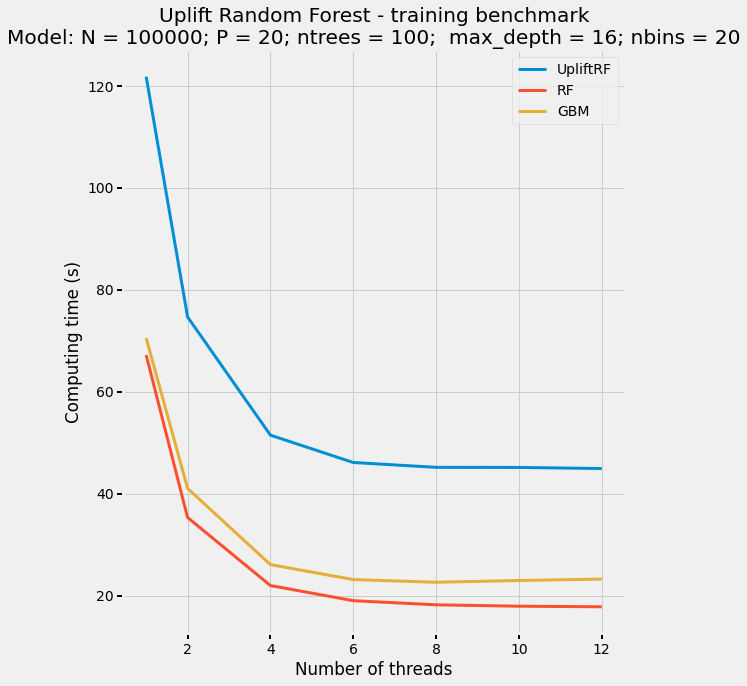

In [23]:
plot_result(uplift_time0, rf_time0, gbm_time0)

In [27]:
N = 100000
P = 20
max_depth = 16
nbins=nbinss[1]
print(f"nbins = {nbins}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [28]:
uplift_time1, rf_time1, gbm_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7wo8qnwd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7wo8qnwd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7wo8qnwd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_osdx5q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.10536575317383s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.66915416717529s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 77.19640231132507s
H2O session _sid_8afc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwxzpfrgm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwxzpfrgm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwxzpfrgm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q6g0zv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.33653116226196s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.47633624076843s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 78.35352754592896s
H2O session _sid_96b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp70w4ed2q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp70w4ed2q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp70w4ed2q\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ouqy84
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.4417564868927s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.776559352874756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.23593258857727s
H2O session _sid_8bcf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpawk6lggq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpawk6lggq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpawk6lggq\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_usq52h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.80144119262695s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.912922859191895s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.0978524684906s
H2O session _sid_8ccb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk9yukuda
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk9yukuda\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk9yukuda\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_z3v1d5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.67796516418457s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.901172161102295s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.72447991371155s
H2O session _sid_b677 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_30i008
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_30i008\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_30i008\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xr5bcr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.88513994216919s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.06749892234802s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 78.61485457420349s
H2O session _sid_a105 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfryt9_sw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfryt9_sw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfryt9_sw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tkczae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.75033712387085s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.09198307991028s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.29122924804688s
H2O session _sid_8502 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa659tr9x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa659tr9x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa659tr9x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lf2xll
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.03167653083801s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.09669876098633s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.86763048171997s
H2O session _sid_80b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpws3592x6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpws3592x6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpws3592x6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qlfadz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.34750747680664s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.441590547561646s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.43326687812805s
H2O session _sid_bb84 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz_i251py
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz_i251py\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz_i251py\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wxnupd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.61465764045715s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 37.37353491783142s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.08015871047974s
H2O session _sid_bfef closed.
Uplift 112.29923784732819s
RF 36.28074510097504s
gbm 79.38953347206116s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsvwuuscw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsvwuuscw\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ejia74
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.26077890396118s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.21851587295532s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.23444056510925s
H2O session _sid_a549 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi1tg6g3i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi1tg6g3i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi1tg6g3i\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_l4jusd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.64592957496643s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.12534308433533s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.6254186630249s
H2O session _sid_98ed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuejwhtun
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuejwhtun\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuejwhtun\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8qanqk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.6606433391571s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.175297021865845s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.51274251937866s
H2O session _sid_8db9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa5n18w1f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa5n18w1f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa5n18w1f\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_45lqlg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.87408065795898s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.22189378738403s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 75.1817307472229s
H2O session _sid_bcee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5rnwp_i0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5rnwp_i0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5rnwp_i0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rrv2dg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.60446643829346s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.15756392478943s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.32598543167114s
H2O session _sid_af49 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7m9t6sjm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7m9t6sjm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7m9t6sjm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2vauv6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.82015490531921s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.07096862792969s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.65451860427856s
H2O session _sid_aa12 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu613onzj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu613onzj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu613onzj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uknxqb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.1899664402008s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.351375102996826s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.34645867347717s
H2O session _sid_9e7d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsr7ienhm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsr7ienhm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsr7ienhm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1xyvpx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.9632465839386s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.08593988418579s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.54742383956909s
H2O session _sid_b234 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwn7w1goe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwn7w1goe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwn7w1goe\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3koc1w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.71131777763367s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.22899627685547s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.72833013534546s
H2O session _sid_b6a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg49h51ur
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg49h51ur\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg49h51ur\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rf76pr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.70393252372742s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.204392194747925s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.33460927009583s
H2O session _sid_9772 closed.
Uplift 104.34345171451568s
RF 34.28402857780456s
gbm 71.8491658449173s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdp6bonxo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdp6bonxo\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1manph
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.76249670982361s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.96861243247986s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.08327651023865s
H2O session _sid_bce8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqqa2sf69
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqqa2sf69\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqqa2sf69\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s038bx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.16172242164612s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.89205765724182s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.90390706062317s
H2O session _sid_9a31 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz5c28yt2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz5c28yt2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz5c28yt2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k7vbbb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.7857575416565s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.24088668823242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.7061698436737s
H2O session _sid_bb05 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzni86aja
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzni86aja\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzni86aja\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h73qp2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.24049091339111s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.05417013168335s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.60854482650757s
H2O session _sid_8be5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptcf0t_mj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptcf0t_mj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptcf0t_mj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qqoiw2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.4808189868927s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.6306688785553s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.93658494949341s
H2O session _sid_9797 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmyorzdoi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmyorzdoi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmyorzdoi\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nv702t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.20136833190918s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.940380573272705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 66.1397213935852s
H2O session _sid_bc8b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcmhzx6qb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcmhzx6qb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcmhzx6qb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jd8sf6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.75541424751282s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.08272695541382s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 66.05921959877014s
H2O session _sid_9585 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpei4guaiu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpei4guaiu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpei4guaiu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i937c4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.33843421936035s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.87638759613037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.83291983604431s
H2O session _sid_a8e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppp5y06ta
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppp5y06ta\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppp5y06ta\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_t0n46n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.7991874217987s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.05445909500122s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.8578953742981s
H2O session _sid_af53 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc181s__f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc181s__f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc181s__f\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3ngyur
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.54671239852905s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.01542615890503s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.61891674995422s
H2O session _sid_809d closed.
Uplift 101.60724031925201s
RF 33.37557761669159s
gbm 65.67471561431884s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyyqm_qu_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyyqm_qu_\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d70xao
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.05529832839966s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.97371792793274s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.40890383720398s
H2O session _sid_a545 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpekwsmqar
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpekwsmqar\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpekwsmqar\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2b0bkh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.49634718894958s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.50391960144043s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.308714866638184s
H2O session _sid_871e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg9h2x3yj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg9h2x3yj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg9h2x3yj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hlz6xt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.08509588241577s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.800349950790405s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.225290298461914s
H2O session _sid_815b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpea7epbvo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpea7epbvo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpea7epbvo\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4yexyb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.40949416160583s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.68622922897339s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.03816509246826s
H2O session _sid_8062 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_vbc_ykm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_vbc_ykm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_vbc_ykm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c2no60
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.5647463798523s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.510589361190796s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 63.66260123252869s
H2O session _sid_8c6d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1hhisp63
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1hhisp63\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1hhisp63\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gr90ad
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.66608500480652s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.902301788330078s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.63721179962158s
H2O session _sid_91e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpausfnc_c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpausfnc_c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpausfnc_c\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kfdu4h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.17700982093811s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.799527168273926s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.33024621009827s
H2O session _sid_9f24 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2vr3jw9e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2vr3jw9e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2vr3jw9e\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_18g04v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.1076021194458s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.3333375453949s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.39213538169861s
H2O session _sid_947b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpskzeajkt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpskzeajkt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpskzeajkt\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2vheqy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.0856728553772s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.805625200271606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.77059984207153s
H2O session _sid_8925 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgac6x10k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgac6x10k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgac6x10k\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6fget2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.04999041557312s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.698260068893433s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.54713010787964s
H2O session _sid_ace9 closed.
Uplift 102.16973421573638s
RF 32.10138578414917s
gbm 62.532099866867064s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf4w7akd2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf4w7akd2\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_elkqm7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.64961409568787s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.00374507904053s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.41698861122131s
H2O session _sid_abbb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5fji8hor
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5fji8hor\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5fji8hor\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hqg1fp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.55769300460815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.14673328399658s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.14194059371948s
H2O session _sid_8ef7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptqtvwilh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptqtvwilh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptqtvwilh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o6cugt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.82127904891968s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.194939851760864s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.63743853569031s
H2O session _sid_b639 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp073v6_a_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp073v6_a_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp073v6_a_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_riayvw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.89928579330444s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.85136413574219s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.232627391815186s
H2O session _sid_8fc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn_bvous9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn_bvous9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn_bvous9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sf9vv1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.02036476135254s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.91461133956909s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.08476495742798s
H2O session _sid_8d01 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb49cynxq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb49cynxq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb49cynxq\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4l7svh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.11573910713196s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.279921770095825s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.15758728981018s
H2O session _sid_9ea6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptncc8kwt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptncc8kwt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptncc8kwt\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hmcu69
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 113.35892987251282s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.15944194793701s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.26610350608826s
H2O session _sid_b730 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpudf3uh3g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpudf3uh3g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpudf3uh3g\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_r42o48
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.10297465324402s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.12224626541138s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.19099760055542s
H2O session _sid_a43b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp93frt3j9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp93frt3j9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp93frt3j9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q0tkug
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.98986268043518s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.87124156951904s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.18261790275574s
H2O session _sid_a8f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpavr8f71b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpavr8f71b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpavr8f71b\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_f1kj7h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.97541737556458s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.20307898521423s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 59.2390022277832s
H2O session _sid_a3df closed.
Uplift 108.74911603927612s
RF 34.47473242282867s
gbm 60.455006861686705s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt22t1e77
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt22t1e77\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o08z3f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 170.05052518844604s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.44229865074158s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.7474753856659s
H2O session _sid_9bea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx1kr0fu8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx1kr0fu8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx1kr0fu8\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_eazqhl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.43328833580017s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.022857427597046s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.73484396934509s
H2O session _sid_aeed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx2k0kmga
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx2k0kmga\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx2k0kmga\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pagzrq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 167.9742624759674s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.39482831954956s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.98701930046082s
H2O session _sid_9971 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpott0jsy9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpott0jsy9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpott0jsy9\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_r6hucy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.53068828582764s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.87448978424072s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.77055644989014s
H2O session _sid_89c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7c8t0zud
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7c8t0zud\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7c8t0zud\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u17dl2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.2882227897644s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.881112813949585s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.77660369873047s
H2O session _sid_937b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqjeu30ps
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqjeu30ps\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqjeu30ps\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_edtg65
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.31637597084045s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.40093183517456s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.4383327960968s
H2O session _sid_9824 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0968kra6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0968kra6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0968kra6\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3q3k2s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.08757305145264s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.214935541152954s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.99701118469238s
H2O session _sid_99d4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4s3cdh7k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4s3cdh7k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4s3cdh7k\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9pngc1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 167.39504480361938s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.92356514930725s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.81866002082825s
H2O session _sid_9d2f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa_kbtbi5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa_kbtbi5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa_kbtbi5\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rlv50r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.04693460464478s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.161049127578735s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.85917663574219s
H2O session _sid_8ab1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc7ljyipt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc7ljyipt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc7ljyipt\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_60kkzg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 167.91776180267334s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.29304909706116s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.21930241584778s
H2O session _sid_9306 closed.
Uplift 168.30406773090363s
RF 53.86091177463531s
gbm 82.33489818572998s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjvexi_c4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjvexi_c4\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8up0q6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.85999631881714s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 101.14575052261353s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 136.1580889225006s
H2O session _sid_a6ba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn0nlx4ek
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn0nlx4ek\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn0nlx4ek\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bfeeei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.81801199913025s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.40299868583679s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 133.60073232650757s
H2O session _sid_8f2b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptrhvtq6y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptrhvtq6y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptrhvtq6y\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0sbizp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.54908299446106s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.065927028656s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.43587112426758s
H2O session _sid_9660 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps3fq1p0x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps3fq1p0x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps3fq1p0x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qfm648
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.5172793865204s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.42380905151367s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 136.76251435279846s
H2O session _sid_b0a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzgitnfzw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzgitnfzw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzgitnfzw\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wbpvc8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.76116585731506s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.19993424415588s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.82960891723633s
H2O session _sid_9bfe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsg8q18fm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsg8q18fm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsg8q18fm\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xwxo7b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.60037446022034s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.45124363899231s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 133.95933175086975s
H2O session _sid_aa93 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf48ttewy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf48ttewy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf48ttewy\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_634xav
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 298.7330825328827s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.29047727584839s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 136.5419499874115s
H2O session _sid_8581 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6oh_dy34
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6oh_dy34\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6oh_dy34\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kgjy11
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.29185676574707s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.35292387008667s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.49173998832703s
H2O session _sid_8e09 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd1_rbfkw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd1_rbfkw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd1_rbfkw\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zxppkp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 300.2755832672119s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.32564759254456s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 137.34228014945984s
H2O session _sid_8d75 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxxbu8mxy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxxbu8mxy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxxbu8mxy\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8170co
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.3818564414978s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.4627799987793s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.6432123184204s
H2O session _sid_85a4 closed.
Uplift 299.87882900238037s
RF 100.0121491909027s
gbm 135.5765329837799s
12 - Uplift = 112.29923784732819, RF = 36.28074510097504, gbm = 79.38953347206116
10 - Uplift = 104.34345171451568, RF = 34.28402857780456, gbm = 71.8491658449173
8 - Uplift = 101.60724031925201, RF = 33.37557761669159, gbm = 65.67471561431884
6 - Uplift = 102.16973421573638, RF = 32.10138578414917, gbm = 62.532099866867064
4 - Uplift = 108.74911603927612, RF = 34.47473242282867, gbm = 60.455006861686705
2 - Uplift = 168.3040

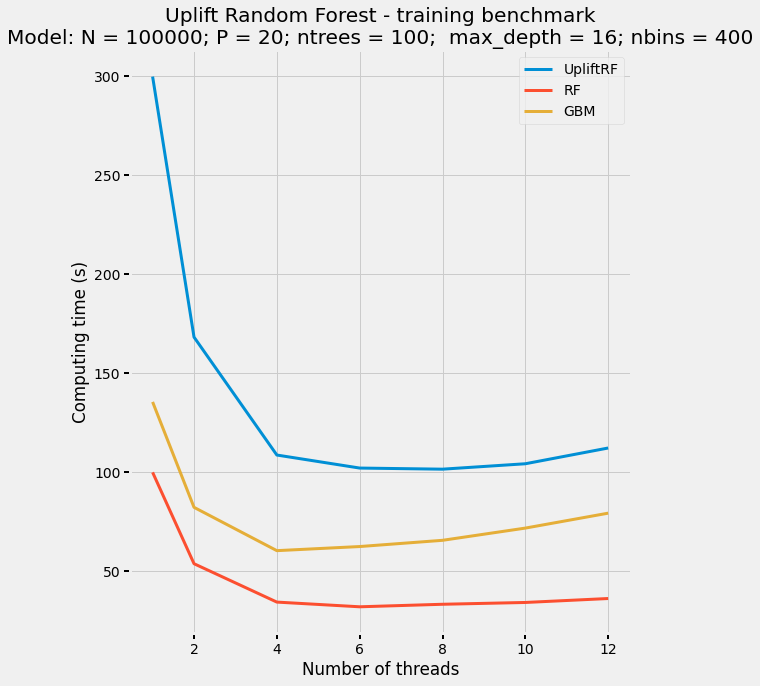

In [29]:
plot_result(uplift_time1, rf_time1, gbm_time1)

In [30]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=nbinss[2]
print(f"nbins = {nbins}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [31]:
uplift_time2, rf_time2, gbm_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv5q3999i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv5q3999i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv5q3999i\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3teczr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.2263960838318s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.46171975135803s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 288.7118282318115s
H2O session _sid_b307 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4dj1e75u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4dj1e75u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4dj1e75u\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lc91lb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 376.61598443984985s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.85928654670715s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 293.5367121696472s
H2O session _sid_9891 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnqbn_y8_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnqbn_y8_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnqbn_y8_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3w39o4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 378.5983316898346s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.35973978042603s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 297.353803396225s
H2O session _sid_8add closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7_hskawj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7_hskawj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7_hskawj\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_brcaiw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 377.7464587688446s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.7144525051117s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 297.8217930793762s
H2O session _sid_9a2d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpff4_bkc6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpff4_bkc6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpff4_bkc6\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_drgc89
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 380.45503067970276s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.13742709159851s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 292.5400605201721s
H2O session _sid_9444 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp92j6lolj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp92j6lolj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp92j6lolj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_fn0tz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.30976915359497s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.91963362693787s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 291.8455352783203s
H2O session _sid_8895 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptguoarcz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptguoarcz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptguoarcz\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s93ovx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 374.5566110610962s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.98106122016907s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 295.4323835372925s
H2O session _sid_98e7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_k7hk5um
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_k7hk5um\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_k7hk5um\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gqji7k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 377.59012722969055s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.12373423576355s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 296.15129828453064s
H2O session _sid_997c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwqc8wvya
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwqc8wvya\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwqc8wvya\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_12ywb8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.1106481552124s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.64079165458679s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 293.46162939071655s
H2O session _sid_8536 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpds0p55x3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpds0p55x3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpds0p55x3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w4lv32
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.32562041282654s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.9485695362091s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 292.2454707622528s
H2O session _sid_af41 closed.
Uplift 378.05349776744845s
RF 106.91464159488677s
gbm 293.9100514650345s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6u30k67b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6u30k67b\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_43husv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 343.4720129966736s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.00976824760437s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 264.54422307014465s
H2O session _sid_9c49 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_wce1pvk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_wce1pvk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_wce1pvk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kq4f1s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 342.2498049736023s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.88641929626465s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 271.5351722240448s
H2O session _sid_a95d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps6m8dyix
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps6m8dyix\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps6m8dyix\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rjw397
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 346.08415150642395s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.02136254310608s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 270.13396692276s
H2O session _sid_8d58 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpymujnszx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpymujnszx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpymujnszx\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6ftesl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 349.7168264389038s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.33276104927063s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 268.9342608451843s
H2O session _sid_917a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnp2avzbb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnp2avzbb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnp2avzbb\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_laukkl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 344.72226071357727s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.89569687843323s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 268.00544714927673s
H2O session _sid_ba6e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpckfkz5_6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpckfkz5_6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpckfkz5_6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_20uynk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.09564208984375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.137451171875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 267.58724904060364s
H2O session _sid_b1f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk4pfnchl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk4pfnchl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk4pfnchl\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tv9snl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 343.47812271118164s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 100.91949391365051s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 271.4358055591583s
H2O session _sid_b13b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4ra1_h3e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4ra1_h3e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4ra1_h3e\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_chv3cu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 342.90254950523376s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.87922143936157s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 269.9146935939789s
H2O session _sid_b34d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6_7vf5ng
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6_7vf5ng\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6_7vf5ng\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_btqan7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.685955286026s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.6771183013916s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 267.2389612197876s
H2O session _sid_9ecb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcd4_ejhy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcd4_ejhy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcd4_ejhy\h2o_potte_started_from_python.err


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_f1vbiw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 341.975389957428s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.84218740463257s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 267.183531999588s
H2O session _sid_8e1f closed.
Uplift 345.1382716178894s
RF 98.96014802455902s
gbm 268.6513311624527s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4zdx11f3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4zdx11f3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7lrsom
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.4343190193176s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.91094040870667s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.67208409309387s
H2O session _sid_b9f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx3eq4dup
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx3eq4dup\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx3eq4dup\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i6jkzh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 321.372220993042s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.49249482154846s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 246.83434224128723s
H2O session _sid_aad1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt21n9g7g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt21n9g7g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt21n9g7g\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jhimru
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.6341772079468s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.7306125164032s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 250.21060395240784s
H2O session _sid_9699 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp54m7lht9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp54m7lht9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp54m7lht9\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_usxs5f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.1318097114563s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.87595868110657s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 246.8759138584137s
H2O session _sid_8b02 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph2sdxk2l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph2sdxk2l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph2sdxk2l\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_y1zav0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 324.44158029556274s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.99919533729553s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 243.97216653823853s
H2O session _sid_88bb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbkxetejy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbkxetejy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbkxetejy\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uhi39w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 325.2886221408844s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.9322247505188s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.7531225681305s
H2O session _sid_b507 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdmb6qoq5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdmb6qoq5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdmb6qoq5\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_772nzt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.6476330757141s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.41953420639038s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 248.73477625846863s
H2O session _sid_896a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmpbp6m_8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmpbp6m_8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmpbp6m_8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o7zeqb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.8079969882965s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.6108329296112s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.8765881061554s
H2O session _sid_9143 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpco0h8b3h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpco0h8b3h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpco0h8b3h\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0fniz8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 325.0884449481964s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.2417151927948s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 246.24785900115967s
H2O session _sid_af35 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdq33yoav
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdq33yoav\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdq33yoav\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1lg410
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 325.25977063179016s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.04321503639221s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 246.68141746520996s
H2O session _sid_824f closed.
Uplift 321.4106575012207s
RF 91.12567238807678s
gbm 246.58588740825653s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5wpxjdsn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5wpxjdsn\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zn2mv0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.02308320999146s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.67367362976074s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 224.75054383277893s
H2O session _sid_b042 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplqa9mc7d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplqa9mc7d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplqa9mc7d\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_j1src8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 306.65382289886475s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.62659072875977s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.52965879440308s
H2O session _sid_94e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbd3hycil
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbd3hycil\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbd3hycil\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_534gt5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 308.2930648326874s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.73812985420227s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.21981167793274s
H2O session _sid_8624 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbqstkzmq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbqstkzmq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbqstkzmq\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2kyzib
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 305.4532117843628s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.88246202468872s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 224.41510701179504s
H2O session _sid_b408 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqq4vpyml
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqq4vpyml\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqq4vpyml\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2ihikg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 305.1566812992096s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.17615485191345s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.15041637420654s
H2O session _sid_b79b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjndizkin
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjndizkin\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjndizkin\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c3qyuc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 306.8340232372284s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.52173376083374s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 225.92858052253723s
H2O session _sid_bbe6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpheyos0ce
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpheyos0ce\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpheyos0ce\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_q6gls3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 303.9575695991516s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.78016090393066s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 226.15598368644714s
H2O session _sid_9568 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt62z4g_p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt62z4g_p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt62z4g_p\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dmmaz0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.7607641220093s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.13312983512878s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.7514533996582s
H2O session _sid_83f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprv3gi2bv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprv3gi2bv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprv3gi2bv\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gj26by
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.80188751220703s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.02293229103088s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.47654819488525s
H2O session _sid_9c36 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm8a26y28
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm8a26y28\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm8a26y28\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ir8n6s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.7192678451538s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.99808621406555s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.62563347816467s
H2O session _sid_b3e9 closed.
Uplift 305.6653376340866s
RF 84.25530540943146s
gbm 224.10037369728087s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeba5f4fk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeba5f4fk\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_b9l54x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.5404043197632s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.24004435539246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.77705097198486s
H2O session _sid_8be2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiffsn3cb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiffsn3cb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiffsn3cb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ja8chd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.93302607536316s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.3111515045166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.75904202461243s
H2O session _sid_926f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp67a3ajjw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp67a3ajjw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp67a3ajjw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vylfn2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.95046758651733s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.8397479057312s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.3217010498047s
H2O session _sid_9e73 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpixmv82ij
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpixmv82ij\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpixmv82ij\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ifx25p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.03152871131897s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.82842326164246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 205.11395597457886s
H2O session _sid_b4bb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpepoc14op
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpepoc14op\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpepoc14op\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c57yf7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 295.7432279586792s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.59634852409363s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 204.5228943824768s
H2O session _sid_b2a6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpek7k1o4z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpek7k1o4z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpek7k1o4z\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nxu9ai
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 298.24736762046814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.76031994819641s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 205.75442337989807s
H2O session _sid_bcbb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4zv3kn7y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4zv3kn7y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4zv3kn7y\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xhz1yq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.3550832271576s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.10453271865845s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 204.0604875087738s
H2O session _sid_920e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjsvlgwi4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjsvlgwi4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjsvlgwi4\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3z7604
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 298.3246359825134s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.05326008796692s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 204.8965721130371s
H2O session _sid_a90a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgrft93jk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgrft93jk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgrft93jk\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g5pd8t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 295.1223113536835s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.98900651931763s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.74985790252686s
H2O session _sid_be41 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphdhl7frx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphdhl7frx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphdhl7frx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zl496g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.9643123149872s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 88.04904437065125s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 207.10136318206787s
H2O session _sid_99a9 closed.
Uplift 296.0212365150452s
RF 85.2771879196167s
gbm 205.70573484897614s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyu6kphcp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyu6kphcp\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ggr84g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.66735339164734s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 121.12035536766052s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.63963723182678s
H2O session _sid_baef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6gdvkqlr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6gdvkqlr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6gdvkqlr\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w4jqb9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 402.85387229919434s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.7154746055603s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.98861503601074s
H2O session _sid_9cab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptin4_wps
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptin4_wps\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptin4_wps\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_94bk7o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.2924175262451s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.46980547904968s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.8414969444275s
H2O session _sid_ba51 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpad9qkdoy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpad9qkdoy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpad9qkdoy\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5nbsoq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.4736087322235s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 121.25144982337952s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.00009036064148s
H2O session _sid_9048 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphbro7bvx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphbro7bvx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphbro7bvx\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ut2p43
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.42300629615784s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.67022013664246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.76882433891296s
H2O session _sid_ae28 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp190a6ngq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp190a6ngq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp190a6ngq\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_z18un7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 408.27985858917236s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 123.12971234321594s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.98851013183594s
H2O session _sid_9eff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_fmuyn_6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_fmuyn_6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_fmuyn_6\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_n9c8p2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.8137333393097s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.44836592674255s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.54219126701355s
H2O session _sid_82dd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvu_h3_6j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvu_h3_6j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvu_h3_6j\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_5s7tq9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 398.58999514579773s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.3012182712555s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.47775554656982s
H2O session _sid_ba3d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp25291yiw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp25291yiw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp25291yiw\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0br3l8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 394.8187916278839s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.88440251350403s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 236.79238510131836s
H2O session _sid_8cc4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8m5e82yv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8m5e82yv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8m5e82yv\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_t0t27n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.332266330719s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.03185749053955s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.45035028457642s
H2O session _sid_a479 closed.
Uplift 401.95449032783506s
RF 121.20228619575501s
gbm 238.54898562431336s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgbxuue96
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgbxuue96\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_pibchs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 671.9789135456085s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 219.26082682609558s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.48480463027954s
H2O session _sid_ad83 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoymp8t4s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoymp8t4s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoymp8t4s\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_87lq96
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 659.6982555389404s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 214.9867603778839s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 351.5068266391754s
H2O session _sid_80cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1w64ao58
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1w64ao58\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1w64ao58\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_v7tn3i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 673.4156112670898s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 216.73023080825806s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.18586921691895s
H2O session _sid_a97b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf5lyq8jn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf5lyq8jn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf5lyq8jn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_bodb6f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 672.1793100833893s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 218.0479953289032s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 355.3433141708374s
H2O session _sid_a396 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu9q0hgdg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu9q0hgdg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu9q0hgdg\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rfw7ce
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 673.8547623157501s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 219.19972157478333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 365.13252353668213s
H2O session _sid_9d95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxs4q5de4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxs4q5de4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxs4q5de4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3z6448
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 667.8766136169434s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 221.14001607894897s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 357.37025213241577s
H2O session _sid_aead closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqimwopma
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqimwopma\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqimwopma\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_mjacfv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 682.777717590332s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 218.15843224525452s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 360.0532932281494s
H2O session _sid_82c3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjylv04zd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjylv04zd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjylv04zd\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rl1q0m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 662.4705111980438s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 224.89526081085205s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 368.52968668937683s
H2O session _sid_81df closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpigsrmyn4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpigsrmyn4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpigsrmyn4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_gqvs5c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 675.9087960720062s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 215.73584532737732s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 358.4349889755249s
H2O session _sid_86f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6auoi72_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6auoi72_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6auoi72_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_n0bjw2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 663.1085805892944s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 217.9430799484253s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 360.84220838546753s
H2O session _sid_8b1a closed.
Uplift 670.3269071817398s
RF 218.60981693267823s
gbm 359.98837676048277s
12 - Uplift = 378.05349776744845, RF = 106.91464159488677, gbm = 293.9100514650345
10 - Uplift = 345.1382716178894, RF = 98.96014802455902, gbm = 268.6513311624527
8 - Uplift = 321.4106575012207, RF = 91.12567238807678, gbm = 246.58588740825653
6 - Uplift = 305.6653376340866, RF = 84.25530540943146, gbm = 224.10037369728087
4 - Uplift = 296.0212365150452, RF = 85.2771879196167, gbm = 205.70573484897614
2 - Uplift = 401.9544

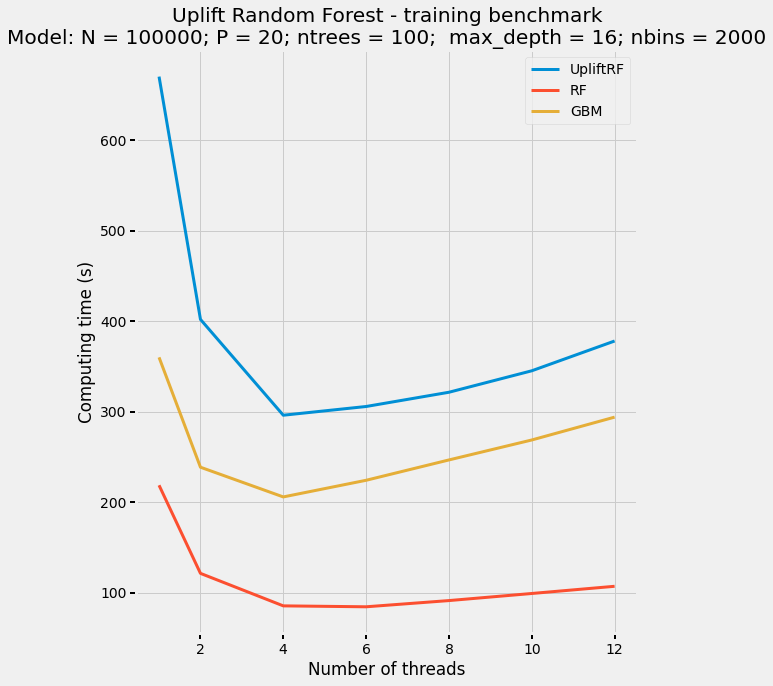

In [32]:
plot_result(uplift_time2, rf_time2, gbm_time2)

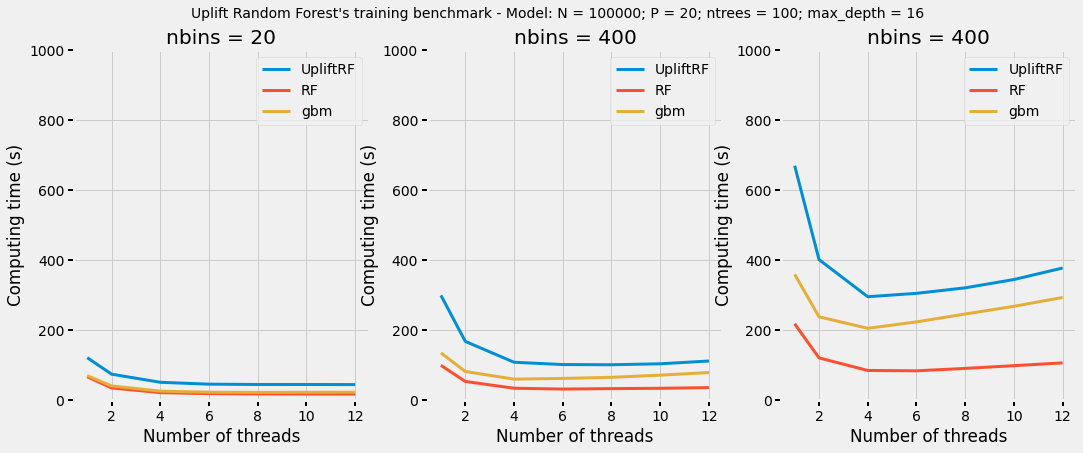

In [33]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"gbm", linewidth=3)    
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [34]:
print(all_predict_uplift)

[{12: 44.916760492324826, 10: 45.13089127540589, 8: 45.15130469799042, 6: 46.10158169269562, 4: 51.47053973674774, 2: 74.66581082344055, 1: 121.82366745471954}, {12: 112.29923784732819, 10: 104.34345171451568, 8: 101.60724031925201, 6: 102.16973421573638, 4: 108.74911603927612, 2: 168.30406773090363, 1: 299.87882900238037}, {12: 378.05349776744845, 10: 345.1382716178894, 8: 321.4106575012207, 6: 305.6653376340866, 4: 296.0212365150452, 2: 401.95449032783506, 1: 670.3269071817398}]


In [35]:
print(all_predict_rf)

[{12: 17.78783812522888, 10: 17.90468246936798, 8: 18.172118830680848, 6: 18.984998917579652, 4: 21.955259013175965, 2: 35.31246917247772, 1: 67.17801783084869}, {12: 36.28074510097504, 10: 34.28402857780456, 8: 33.37557761669159, 6: 32.10138578414917, 4: 34.47473242282867, 2: 53.86091177463531, 1: 100.0121491909027}, {12: 106.91464159488677, 10: 98.96014802455902, 8: 91.12567238807678, 6: 84.25530540943146, 4: 85.2771879196167, 2: 121.20228619575501, 1: 218.60981693267823}]


In [36]:
print(all_predict_gbm)

[{12: 23.225254225730897, 10: 22.945911693573, 8: 22.604360723495482, 6: 23.12412223815918, 4: 26.069065523147582, 2: 41.016525053977965, 1: 70.51763026714325}, {12: 79.38953347206116, 10: 71.8491658449173, 8: 65.67471561431884, 6: 62.532099866867064, 4: 60.455006861686705, 2: 82.33489818572998, 1: 135.5765329837799}, {12: 293.9100514650345, 10: 268.6513311624527, 8: 246.58588740825653, 6: 224.10037369728087, 4: 205.70573484897614, 2: 238.54898562431336, 1: 359.98837676048277}]


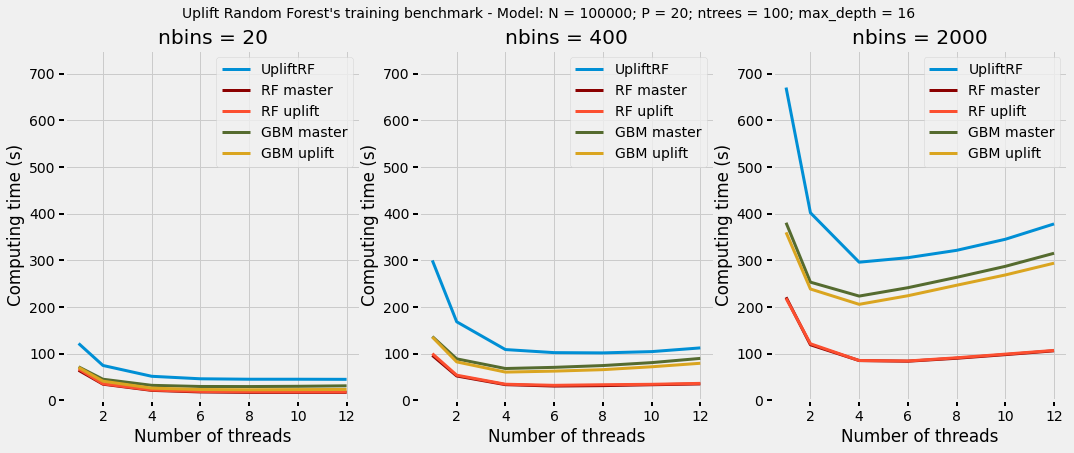

In [21]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf_uplift = [rf_time0, rf_time1, rf_time2]
all_predict_gbm_uplift = [gbm_time0, gbm_time1, gbm_time2]
all_predict_gbm_master = [{12: 31.045402455329896, 10: 30.003125166893007, 8: 29.459724402427675, 6: 29.618798065185548, 4: 32.065751457214354, 2: 45.13592867851257, 1: 71.67515115737915}, {12: 89.81329185962677, 10: 80.74043428897858, 8: 74.46653089523315, 6: 70.61683766841888, 4: 68.13480970859527, 2: 88.81703267097473, 1: 136.62510740756989}, {12: 315.1842556476593, 10: 287.11348288059236, 8: 263.5495444536209, 6: 241.33826262950896, 4: 223.3799422979355, 2: 253.20618925094604, 1: 380.59573593139646}]
all_predict_rf_master = [{12: 16.969228744506836, 10: 16.93504798412323, 8: 16.9992112159729, 6: 17.891290044784547, 4: 21.27529604434967, 2: 34.54790048599243, 1: 64.3570431470871}, {12: 35.09399790763855, 10: 33.34315853118896, 8: 31.443611669540406, 6: 30.545160150527956, 4: 33.5466162443161, 2: 52.15320856571198, 1: 96.24524054527282}, {12: 106.10161943435669, 10: 97.87103872299194, 8: 90.09002497196198, 6: 83.78771808147431, 4: 85.18966431617737, 2: 119.04548950195313, 1: 220.81866981983185}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color = "darkgoldenrod")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")      
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 750)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()